# Imports

In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
3
NVIDIA GeForce RTX 3090


In [2]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler, create_dataloaders, discard_random_labels, remove_duplicates_preserve_order, order_labels_and_array_with_target
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits, export_dynamic_orbits_html
from orbit_generation.stats import plot_histograms_comparison
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model_factory import get_model
from orbit_generation.architectures import VAELossHistory
from orbit_generation.propagation import jacobi_constant, calculate_errors_per_orbit
from orbit_generation.experiment import setup_new_experiment, add_experiment_metrics, plot_corr_matrix, get_experiment_data
from orbit_generation.evaluation import evaluate_clustering_multiple_labels, find_nearest_orbits_batch, calculate_pairwise_orbit_distances, calculate_distances_batch, find_nearest_points_batch, calculate_pairwise_distances, find_nearest_orbits
from orbit_generation.latent_space import sample_random_distributions, plot_2d_latent_space, plot_combined_2d_latent_space, reduce_dimensions_latent_space, compute_centroids, grid_sample
from orbit_generation.convergence import process_diferential_correction_orbits

In [3]:
import numpy as np
import pandas as pd
import os
from pytorch_lightning import Trainer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Parameters

In [4]:
want_to_train = True   # Set this parameter to False if you want to load the model from the folder
want_to_generate = True    # Set this parameter to False if you want to load the generation from the folder
calculate_error_metrics = True   # Set this parameter to False if you don't want to calculate any metric
want_to_get_cluster_metrics = True    # Set this parameter to False if you don't want to calculate clustering metrics
want_to_perform_convergence = True   # Set this parameter to False if you don't want to perform convergence
want_to_discover = True            # Set this parameter to False if you don't want to study the discovery

assert want_to_train==want_to_discover

In [5]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [31]:
params = {
    # Data
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'families_to_discard' : 10,
    'seq_len': 100,
    'feature_dim': 7,
    # Training
    'epochs': 15,
    'val_split': 0.05,
    'batch_size': 32,
    'lr': 0.001,
    # Model
    'model_name': 'inception_time_wp_vae',
    'latent_dim': 2,
    'model_kwargs' : {'beta': 1, 'n_filters' : 32, 'kernel_sizes' : [3, 5, 13], 'bottleneck_channels': 32},
    # Convergence
    'max_iter_convergence' : 20,
    'input_seq_len_convergence' : 100,
    # Evaluation
    'samples_to_generate' : 100,
    'distance_metric' : 'euclidean'
}

In [7]:
# 'model_kwargs' : {'beta': 1, 'n_filters' : 8, 'kernel_sizes' : [3,7,13], 'bottleneck_channels': 8}
# 'model_kwargs' : {'beta': 1, 'dropout_rate': 0.2},

# Saving paths

In [8]:
# Experiment
experiment_folder = setup_new_experiment(params, experiments_folder)
images_folder = os.path.join(experiment_folder, 'images')
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
experiment_id = os.path.basename(experiment_folder).split('_')[1]

Parameters already exist for experiment: ../experiments/experiment_23


In [9]:
# Images
## Orbits
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.png')
dynamical_refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')
generated_orbits_that_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_converged.png')
generated_orbits_that_did_not_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_not_converged.png')
## Latent Spaces
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
full_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_full_latent_space')
discarded_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_discarded_latent_space')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
combined_latent_space_arrows_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space_arrows')
family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids')
full_family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_full_family_centroids')
## Feature Spaces
features_plot_path = os.path.join(images_folder, f'exp{experiment_id}_features')
family_feature_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_feature_centroids')
## Other
model_losses_path = os.path.join(images_folder, f'exp{experiment_id}_model_losses.png')
histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_histogram_comparison.png')
full_histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_full_histogram_comparison.png')

# Model
model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model.pth')

# Orbits
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.npy')
refined_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits.npy')

# Latent Representations
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
family_centroids_path = os.path.join(experiment_folder, f'exp{experiment_id}_family_centroids.npy')

# Features
generation_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_generation_df.csv')
refined_orbits_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits_df.csv')


# Data

## Import

In [10]:
full_data, full_orbit_df, full_labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
full_data.shape

(45211, 7, 100)

Remove the time variable if specified in params

In [11]:
if params['feature_dim']==6:
    full_data=full_data[:,1:,:]
    full_data.shape

Remove specific families from the training data

In [12]:
full_orbits_id_classes = [full_orbit_df.at[index, 'id_class'] for index in full_labels]

if want_to_discover:
    discarded_family_ids, data, orbits_id_classes = discard_random_labels(full_data, np.array(full_orbits_id_classes), params['families_to_discard'])
    discarded_families = get_orbit_classes(discarded_family_ids)[0]
    orbit_df = full_orbit_df[~full_orbit_df['id_class'].isin(discarded_family_ids)]
    add_experiment_metrics(experiments_folder, params=params,
                           metrics={'discarded_family_ids':discarded_family_ids, 'discarded_families':discarded_families})

else:
    experiment_data = get_experiment_data(experiments_folder=experiments_folder, experiment_id=experiment_id)
    discarded_family_ids = experiment_data.get('discarded_family_ids', {})
    discarded_family_ids, data, orbits_id_classes = discard_random_labels(full_data, np.array(full_orbits_id_classes), discarded_family_ids)
    discarded_families = get_orbit_classes(discarded_family_ids)[0]
    orbit_df = full_orbit_df[~full_orbit_df['id_class'].isin(discarded_family_ids)]

discarded_families

Metrics added to experiment with ID 23 in ../experiments/experiments.json.


['S_L3_A',
 'S_DPO',
 'S_L4_A',
 'S_L1_A',
 'S_L2_L',
 'S_L5_V',
 'S_R23',
 'S_L1_V',
 'S_L3_V',
 'S_L2_HS']

Get Features

In [13]:
discarded_family_ids

[17.0, 4.0, 22.0, 7.0, 15.0, 29.0, 37.0, 11.0, 21.0, 14.0]

In [14]:
orbit_df.shape

(33786, 11)

In [15]:
family_labels = get_orbit_classes(orbits_id_classes)[0]

feature_names=['jacobi', 'period', 'stability']
features=orbit_df[feature_names].to_numpy()

## Scaling

In [16]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data.shape

torch.Size([33786, 7, 100])

# Modelling

In [27]:
import importlib
import orbit_generation.model_factory as model_factory
import orbit_generation.architectures as architectures
import orbit_generation.vae as vae

# Reload the model_factory module
importlib.reload(model_factory)
importlib.reload(vae)
importlib.reload(architectures)

# Re-import the updated `get_model` function
from orbit_generation.model_factory import get_model

In [28]:
model = get_model(params)

In [29]:
if want_to_train:
    train_loader, val_loader = create_dataloaders(scaled_data, val_split=params.get('val_split', 0.1), batch_size=params.get('batch_size', 32))

    loss_history = VAELossHistory()

    trainer = Trainer(
        max_epochs=params.get('epochs', 10),
        log_every_n_steps=10,
        devices="auto",
        accelerator="auto",
        enable_progress_bar=True,
        enable_model_summary=True,
        callbacks=[loss_history]
    )

    trainer.fit(model, train_loader, val_loader)

    for metric_name, metric_value in trainer.callback_metrics.items():
        print(f"{metric_name}: {metric_value}")

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name          | Type                      | Params | Mode 
--------------------------------------------------------------------
0 | encoder       | WPInceptionTimeVAEEncoder | 5.2 M  | train
1 | decoder       | WPInceptionTimeVAEDecoder | 5.6 M  | train
2 | sampling      | Sampling                  | 0      | train
3 | train_metrics | MetricCollection          | 0      | train
4 | val_metrics   | MetricCollection          | 0      | train
--------------------------------------------------------------------
10.8 M    Trainable params
0         Non-trainable params
10.8 M    Total params
43.293    Total estimated model params size (MB)
166       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


val_total_loss: 5.594226837158203
val_reconstruction_loss: 1.905501365661621
val_kl_loss: 3.6887245178222656
train_total_loss: 6.032435417175293
train_reconstruction_loss: 2.2375853061676025
train_kl_loss: 3.7948496341705322


Metrics added to experiment with ID 23 in ../experiments/experiments.json.


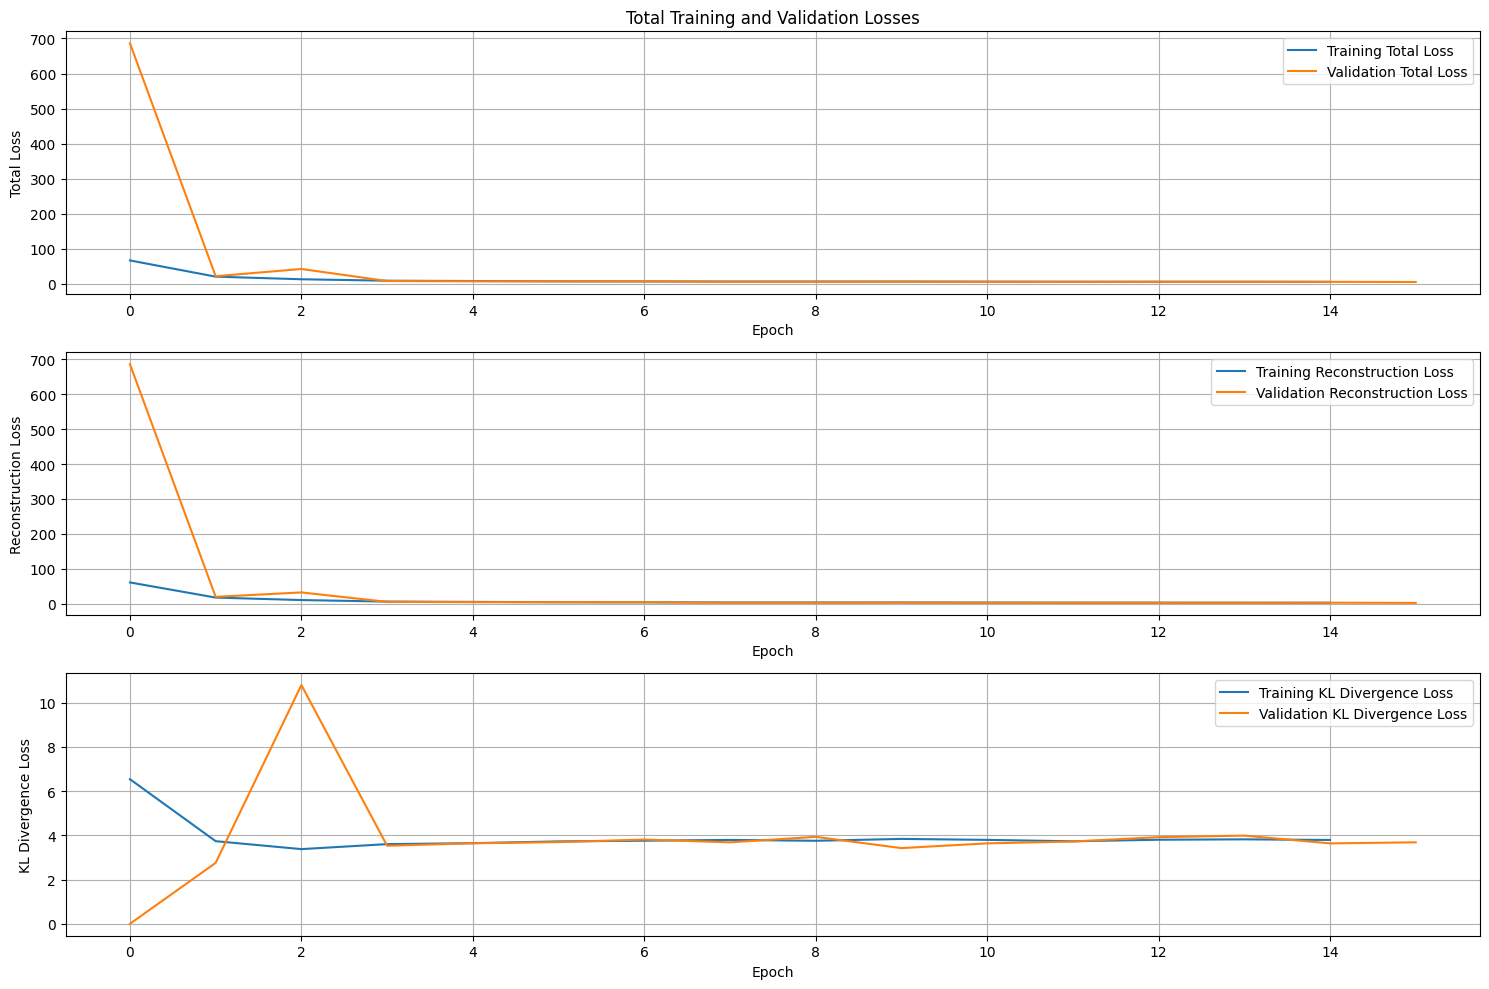

In [32]:
if want_to_train:
    add_experiment_metrics(experiments_folder, params=params, metrics=trainer.callback_metrics)
    torch.save(model.state_dict(), model_save_path)
    loss_history.plot_all_losses(save_path=model_losses_path)
else:
    model.load_state_dict(torch.load(model_save_path, weights_only=True))  

# Latent Space

## Dataset

In [33]:
if params['model_name']=='vae_inception_time':
    latent_means, latent_log_vars, _ = model.encode(scaled_data)
else:
    latent_means, latent_log_vars = model.encode(scaled_data)

latent_means = latent_means.detach().numpy()
latent_log_vars = latent_log_vars.detach().numpy()
latent_representation = np.concatenate((latent_means, latent_log_vars), axis=1)
np.save(latent_representations_path, latent_representation)
latent_representation.shape

(33786, 4)

In [34]:
latent_log_vars = torch.from_numpy(latent_log_vars)
latent_stdevs = torch.exp(0.5 * latent_log_vars)
latent_stdevs = latent_stdevs.numpy()
latent_stdevs.shape

(33786, 2)

In [35]:
features.shape

(33786, 3)

Saved plot to ../experiments/experiment_23/images/exp23_latent_space


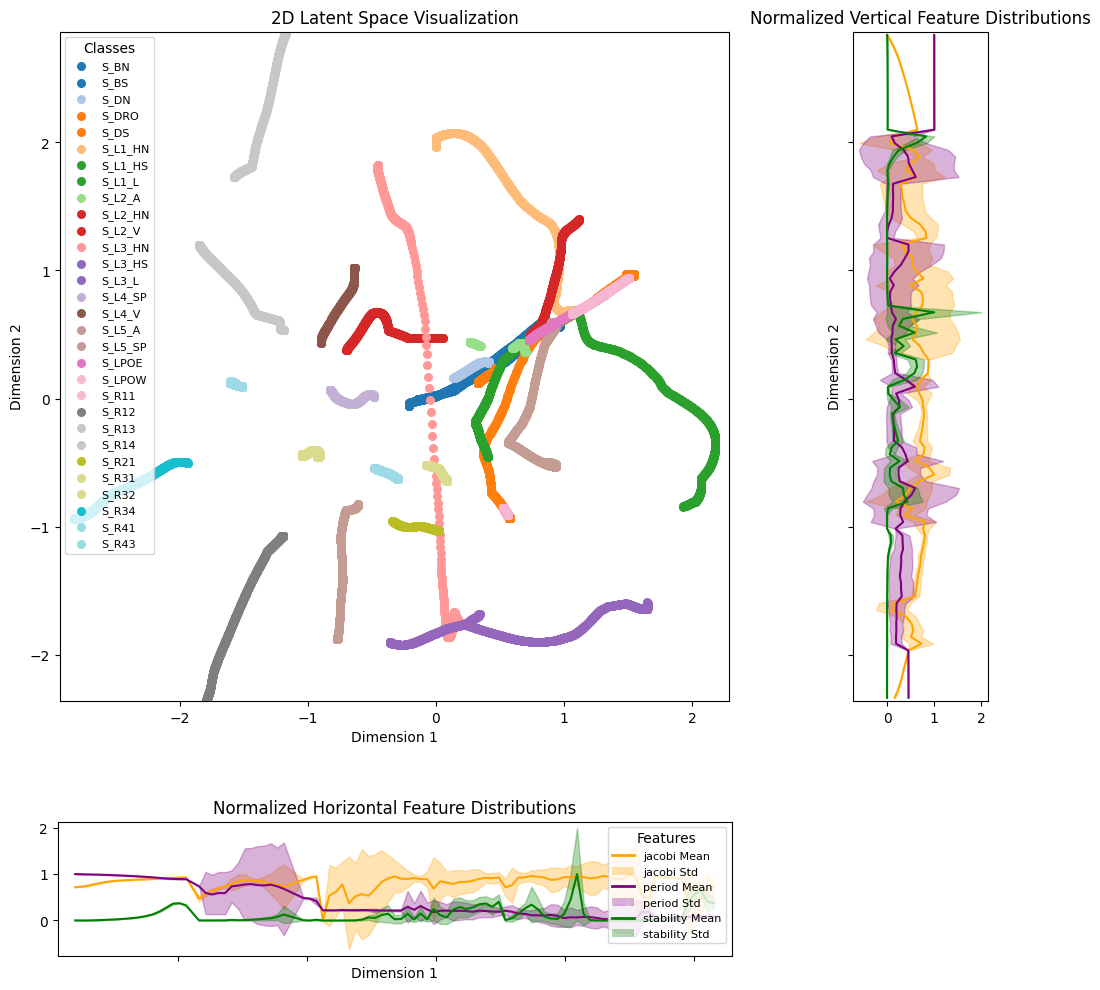

In [53]:
if latent_means.shape[1]==2:
    plot_2d_latent_space(latent_means,
                            np.array(family_labels),
                            save_path=latent_space_path,
                            features=features,
                            feature_names=feature_names,
                            plot_std=True)
else:
    rls=reduce_dimensions_latent_space(latent_means,
                                        np.array(family_labels),
                                        techniques=['PCA','UMAP','t-SNE'],
                                        save_path=latent_space_path,
                                        show_legend=False,
                                        latent_stdevs=latent_stdevs)

### Full Dataset

In [37]:
# Scale full data
full_scaled_data = scaler.transform(torch.tensor(full_data, dtype=torch.float32))

# Encode full data
if params['model_name']=='vae_inception_time':
    full_latent_means, full_latent_log_vars, _ = model.encode(full_scaled_data)
else:
    full_latent_means, full_latent_log_vars= model.encode(full_scaled_data)

full_latent_means = full_latent_means.detach().numpy()

# Calculate stdevs
full_latent_stdevs = torch.exp(0.5 * full_latent_log_vars)
full_latent_stdevs = full_latent_stdevs.detach().numpy()
full_latent_stdevs.shape

(45211, 2)

In [38]:
full_family_labels=get_orbit_classes(full_orbits_id_classes)[0]
family_labels_discarded_train = [label if label in discarded_families else 'training' for label in full_family_labels]
family_labels_discarded_train = np.array(family_labels_discarded_train)
family_labels_discarded_train.shape

(45211,)

In [39]:
full_features=full_orbit_df[feature_names].to_numpy()
full_features.shape

(45211, 3)

Saved plot to ../experiments/experiment_23/images/exp23_full_latent_space


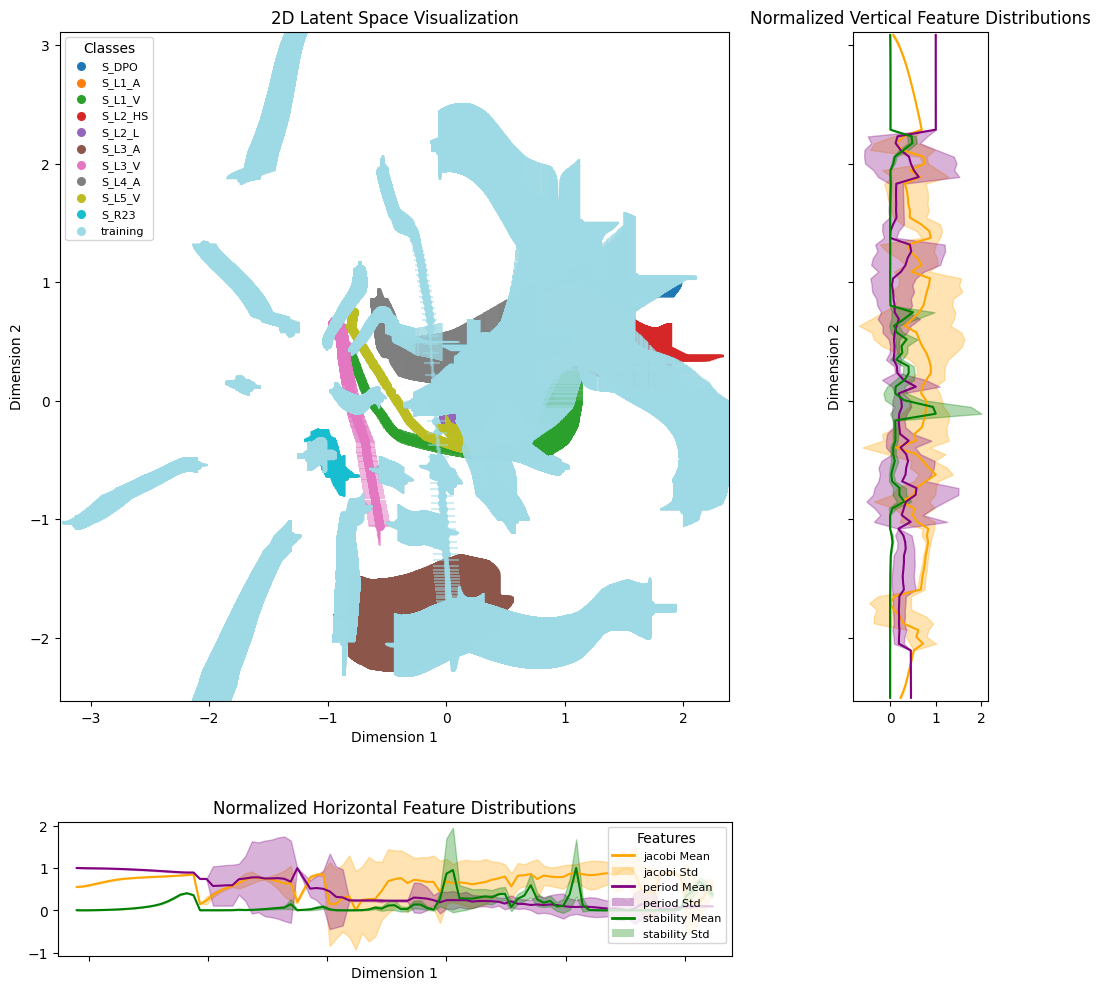

In [40]:
if full_latent_means.shape[1]==2:
    plot_2d_latent_space(full_latent_means,
                            family_labels_discarded_train,
                            save_path=full_latent_space_path,
                            features=full_features,
                            feature_names=feature_names,
                            plot_std=True,
                            latent_stdevs=full_latent_stdevs)

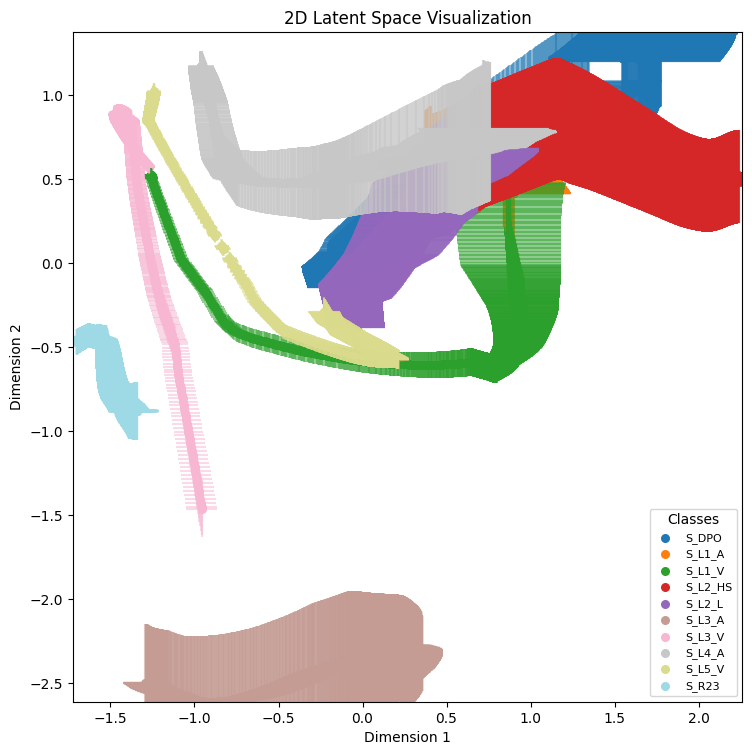

In [41]:
discarded_orbit_indices = [i for i in range(len(family_labels_discarded_train)) if family_labels_discarded_train[i] != 'training']

if full_latent_means.shape[1]==2:
    plot_2d_latent_space(full_latent_means[discarded_orbit_indices],
                            family_labels_discarded_train[discarded_orbit_indices],
                            save_path=discarded_latent_space_path,
                            features=full_features[discarded_orbit_indices],
                            latent_stdevs=full_latent_stdevs[discarded_orbit_indices])


## Centroids

In [42]:
# Compute centroids
centroid_means = compute_centroids(latent_means, orbits_id_classes, method='mean')
centroid_log_vars = compute_centroids(latent_log_vars, orbits_id_classes, method='mean')
centroids_representation = np.concatenate((centroid_means, centroid_log_vars), axis=1)
np.save(family_centroids_path, centroids_representation)
centroid_log_vars = torch.from_numpy(centroid_log_vars)
centroid_stdevs = torch.exp(0.5 * centroid_log_vars)
centroid_stdevs = centroid_stdevs.numpy()
centroid_stdevs.shape

(30, 2)

In [43]:
# Compute centroid labels
unique_classes = remove_duplicates_preserve_order(orbits_id_classes)
family_names=get_orbit_classes(unique_classes)[0]
len(family_names)

30

In [44]:
# Compute full data centroid
full_data_centroid = np.mean(latent_means, axis=0)
full_data_centroid

array([ 0.08288407, -0.0123785 ], dtype=float32)

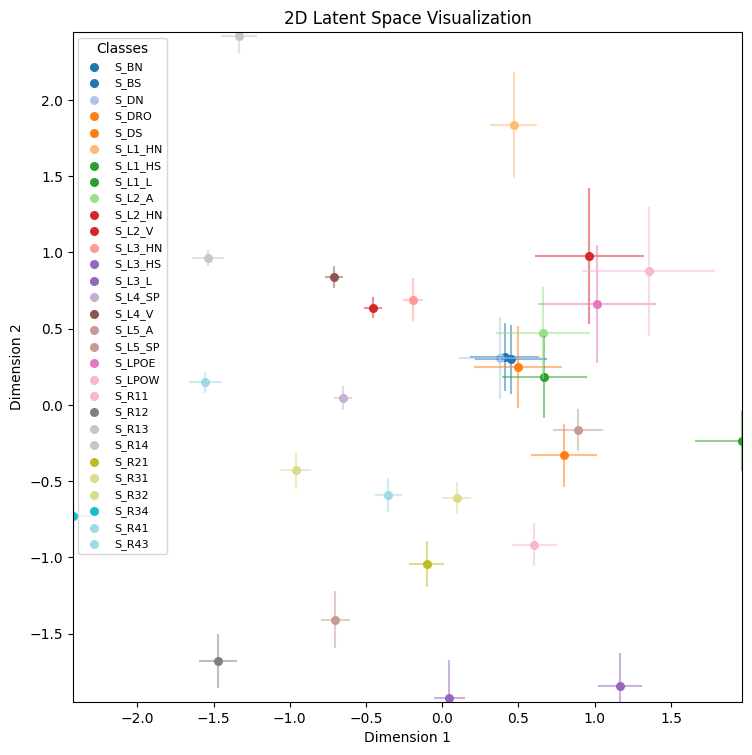

In [45]:
if latent_means.shape[1]==2:
    plot_2d_latent_space(centroid_means,
                            np.array(family_names),
                            save_path=family_centroids_plot_path,
                            latent_stdevs=centroid_stdevs
                            )
else:
    rls=reduce_dimensions_latent_space(centroid_means,
                                        np.array(family_names),
                                        techniques=['PCA','UMAP','t-SNE'],
                                        save_path=family_centroids_plot_path,
                                        show_legend=False)

### Full Centroids

In [46]:
# Compute centroids
full_centroid_means = compute_centroids(full_latent_means, full_orbits_id_classes, method='mean')
full_centroid_log_vars = compute_centroids(full_latent_log_vars.detach().numpy(), full_orbits_id_classes, method='mean')
full_centroid_stdevs = compute_centroids(full_latent_stdevs, full_orbits_id_classes, method='mean')
full_centroid_stdevs.shape

(40, 2)

In [47]:
# Calculate full centroid labels
full_unique_classes = remove_duplicates_preserve_order(full_orbits_id_classes)
full_family_names=get_orbit_classes(full_unique_classes)[0]
len(full_family_names)

40

In [48]:
families_discarded_train = [label if label in discarded_families else 'training' for label in full_family_names]
families_discarded_train = np.array(families_discarded_train)
len(families_discarded_train)

40

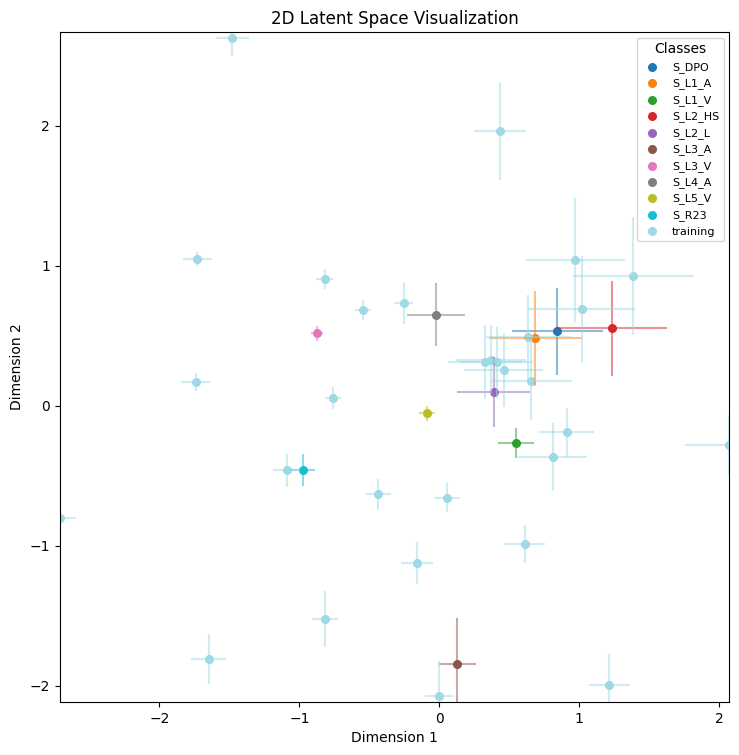

In [49]:
if full_centroid_means.shape[1]==2:
    plot_2d_latent_space(full_centroid_means,
                            families_discarded_train,
                            save_path=full_family_centroids_plot_path,
                            latent_stdevs=full_centroid_stdevs
                            )

In [50]:
discarded_family_indices = [i for i in range(len(families_discarded_train)) if families_discarded_train[i] != 'training']
discarded_centroid_means = full_centroid_means[discarded_family_indices]
discarded_centroid_log_vars = full_centroid_log_vars[discarded_family_indices]
discarded_centroid_log_vars.shape

(10, 2)

## Clustering

In [51]:
if want_to_get_cluster_metrics:
    cluster_metrics = evaluate_clustering_multiple_labels(latent_means, [family_labels], label_names=['family'], clustering_method='gmm')
    add_experiment_metrics(experiments_folder, params=params, metrics=cluster_metrics)

Metrics added to experiment with ID 23 in ../experiments/experiments.json.


# Generation

Normal Sampling

In [54]:
if want_to_generate:
    random_generation = model.sample(params['samples_to_generate'])
    random_generation = scaler.inverse_transform(random_generation)
    print(random_generation.shape)

torch.Size([100, 7, 100])


Discarded Centroid Sampling

In [55]:
if want_to_generate:
    discarded_centroids_latent_samples = sample_random_distributions(discarded_centroid_means, discarded_centroid_log_vars, params['samples_to_generate'])
    discarded_centroids_generation = model.decode(discarded_centroids_latent_samples)
    discarded_centroids_generation = scaler.inverse_transform(discarded_centroids_generation)
    print(discarded_centroids_generation.shape)

torch.Size([100, 7, 100])


Grid Sampling

In [61]:
if want_to_generate:
    grid_samples = grid_sample(centroid_means, grid_size=(10,10))
    grid_generation = model.decode(torch.from_numpy(grid_samples))
    grid_generation = scaler.inverse_transform(grid_generation)
    print(grid_generation.shape)

torch.Size([100, 7, 100])


Save or Load

In [62]:
if want_to_generate:
    generation = torch.cat([random_generation, discarded_centroids_generation, grid_generation], dim=0)
    generation = generation.detach().cpu().numpy()
    np.save(generated_data_path, random_generation.detach().numpy())
else:
    generation = np.load(generated_data_path)

## Visualization

In [63]:
if torch.is_tensor(generation):
    generation=generation.detach().numpy()

if generation.shape[1] == 7:
    no_time_generation = generation[:,1:,:]
    generation.shape
else:
    no_time_generation = generation

no_time_generation.shape

(300, 6, 100)

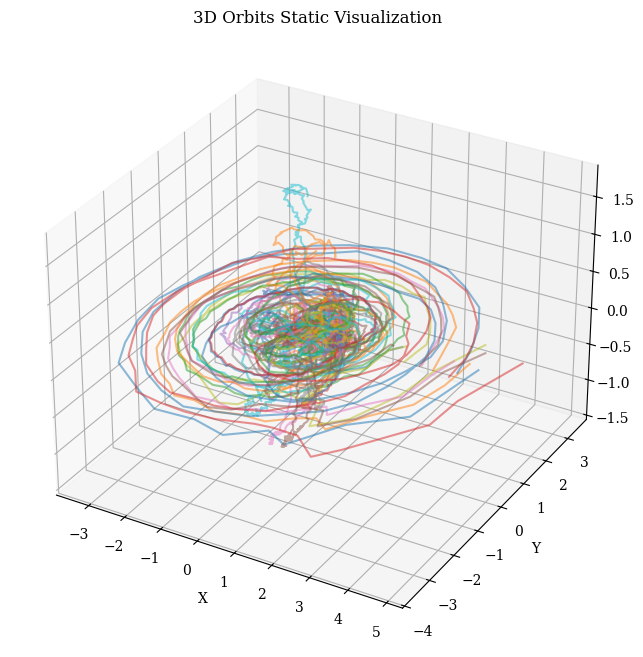

In [64]:
visualize_static_orbits(data= no_time_generation[0:100], show_legend=False, save_path=static_all_orbit_path)

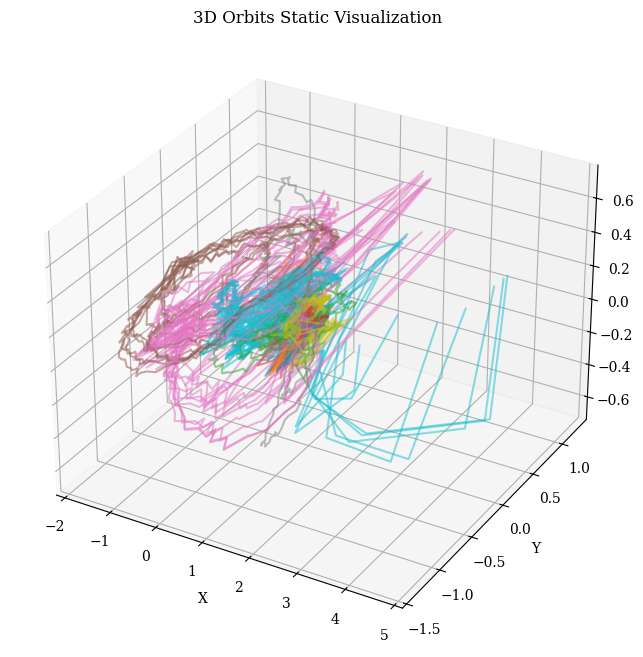

In [65]:
visualize_static_orbits(data= no_time_generation[100:200], show_legend=False)

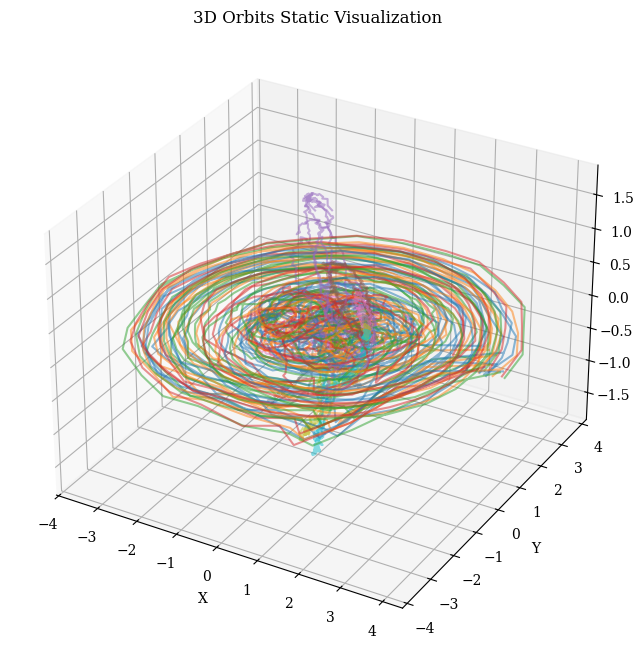

In [66]:
visualize_static_orbits(data= no_time_generation[200:300], show_legend=False)

In [67]:
export_dynamic_orbits_html(data=no_time_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_23/images/exp23_generated_orbits.html


## Coverage

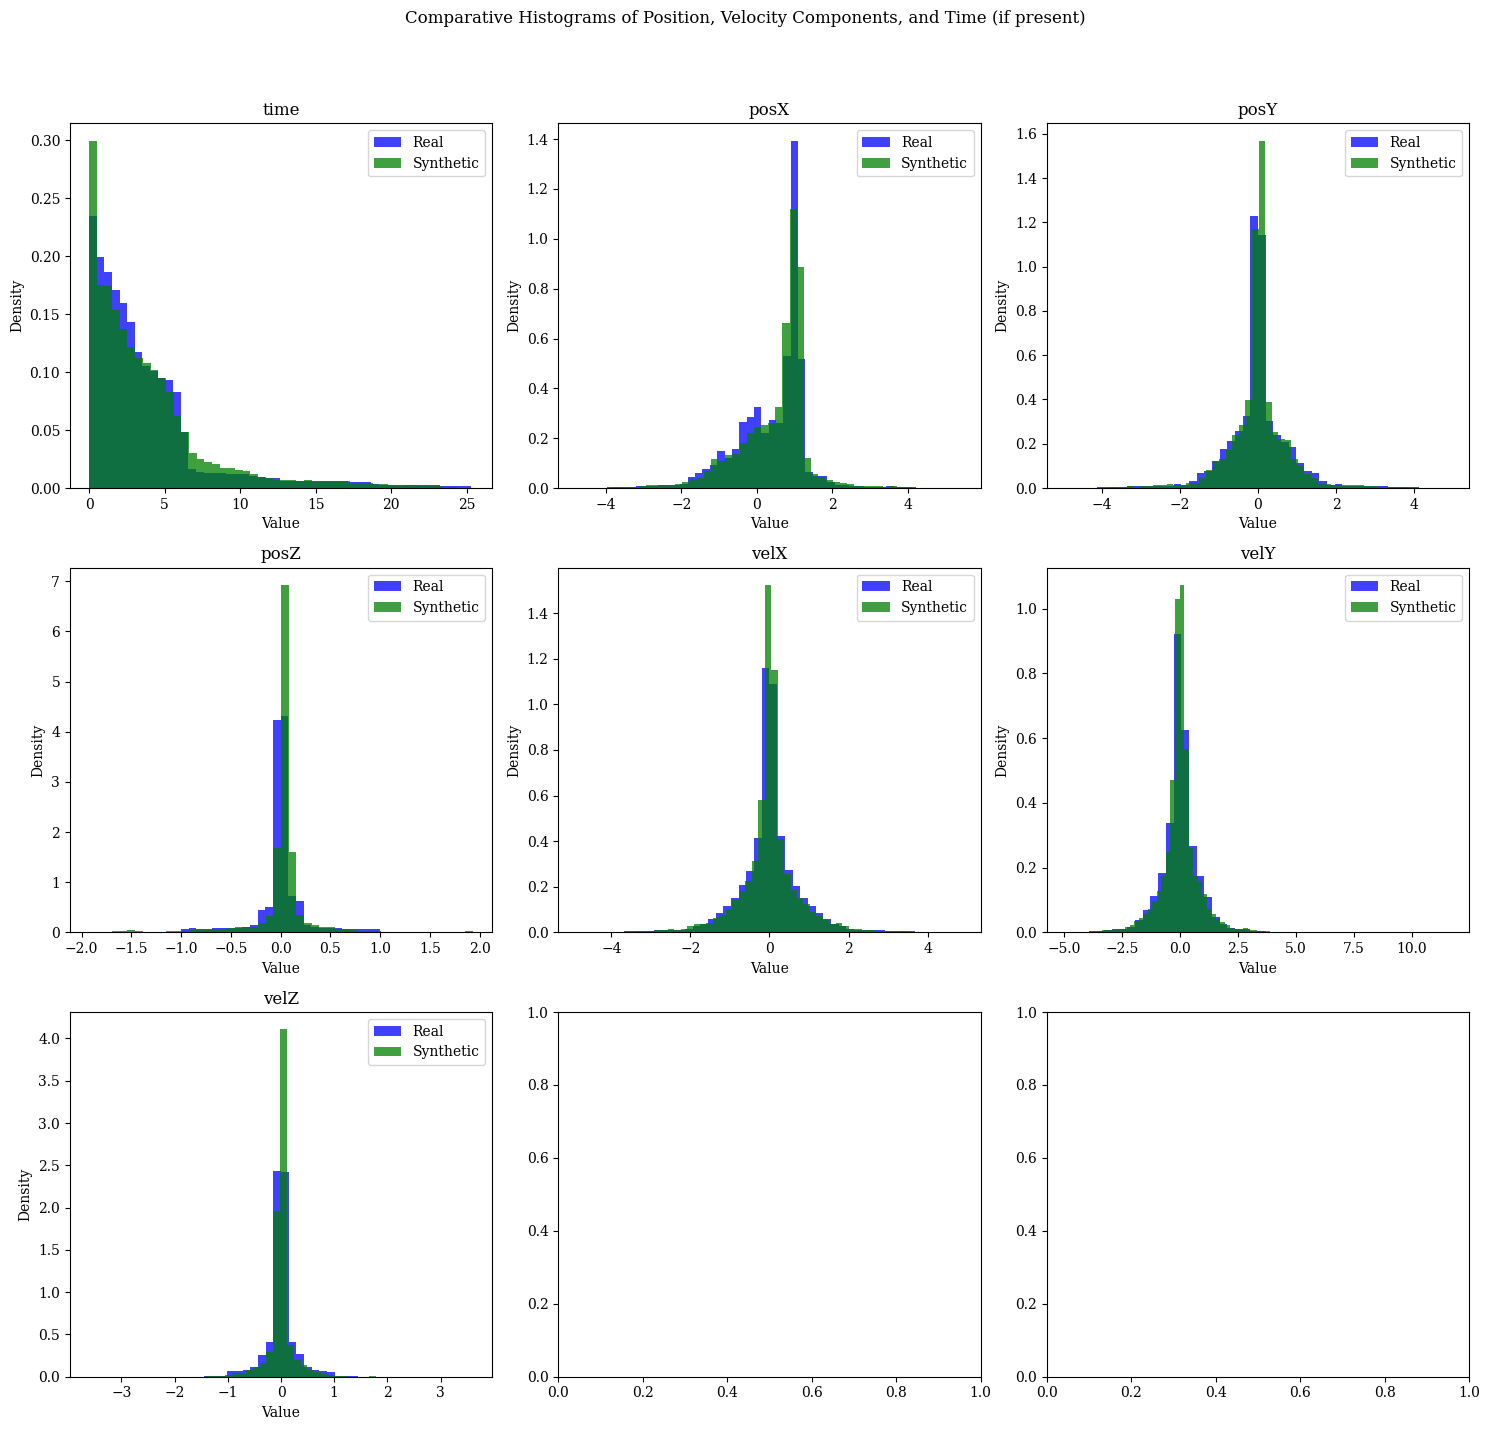

In [68]:
plot_histograms_comparison(data1=data, data2=generation, label1='Real', label2='Synthetic', normalize=True, save_path=histogram_comparison_path)

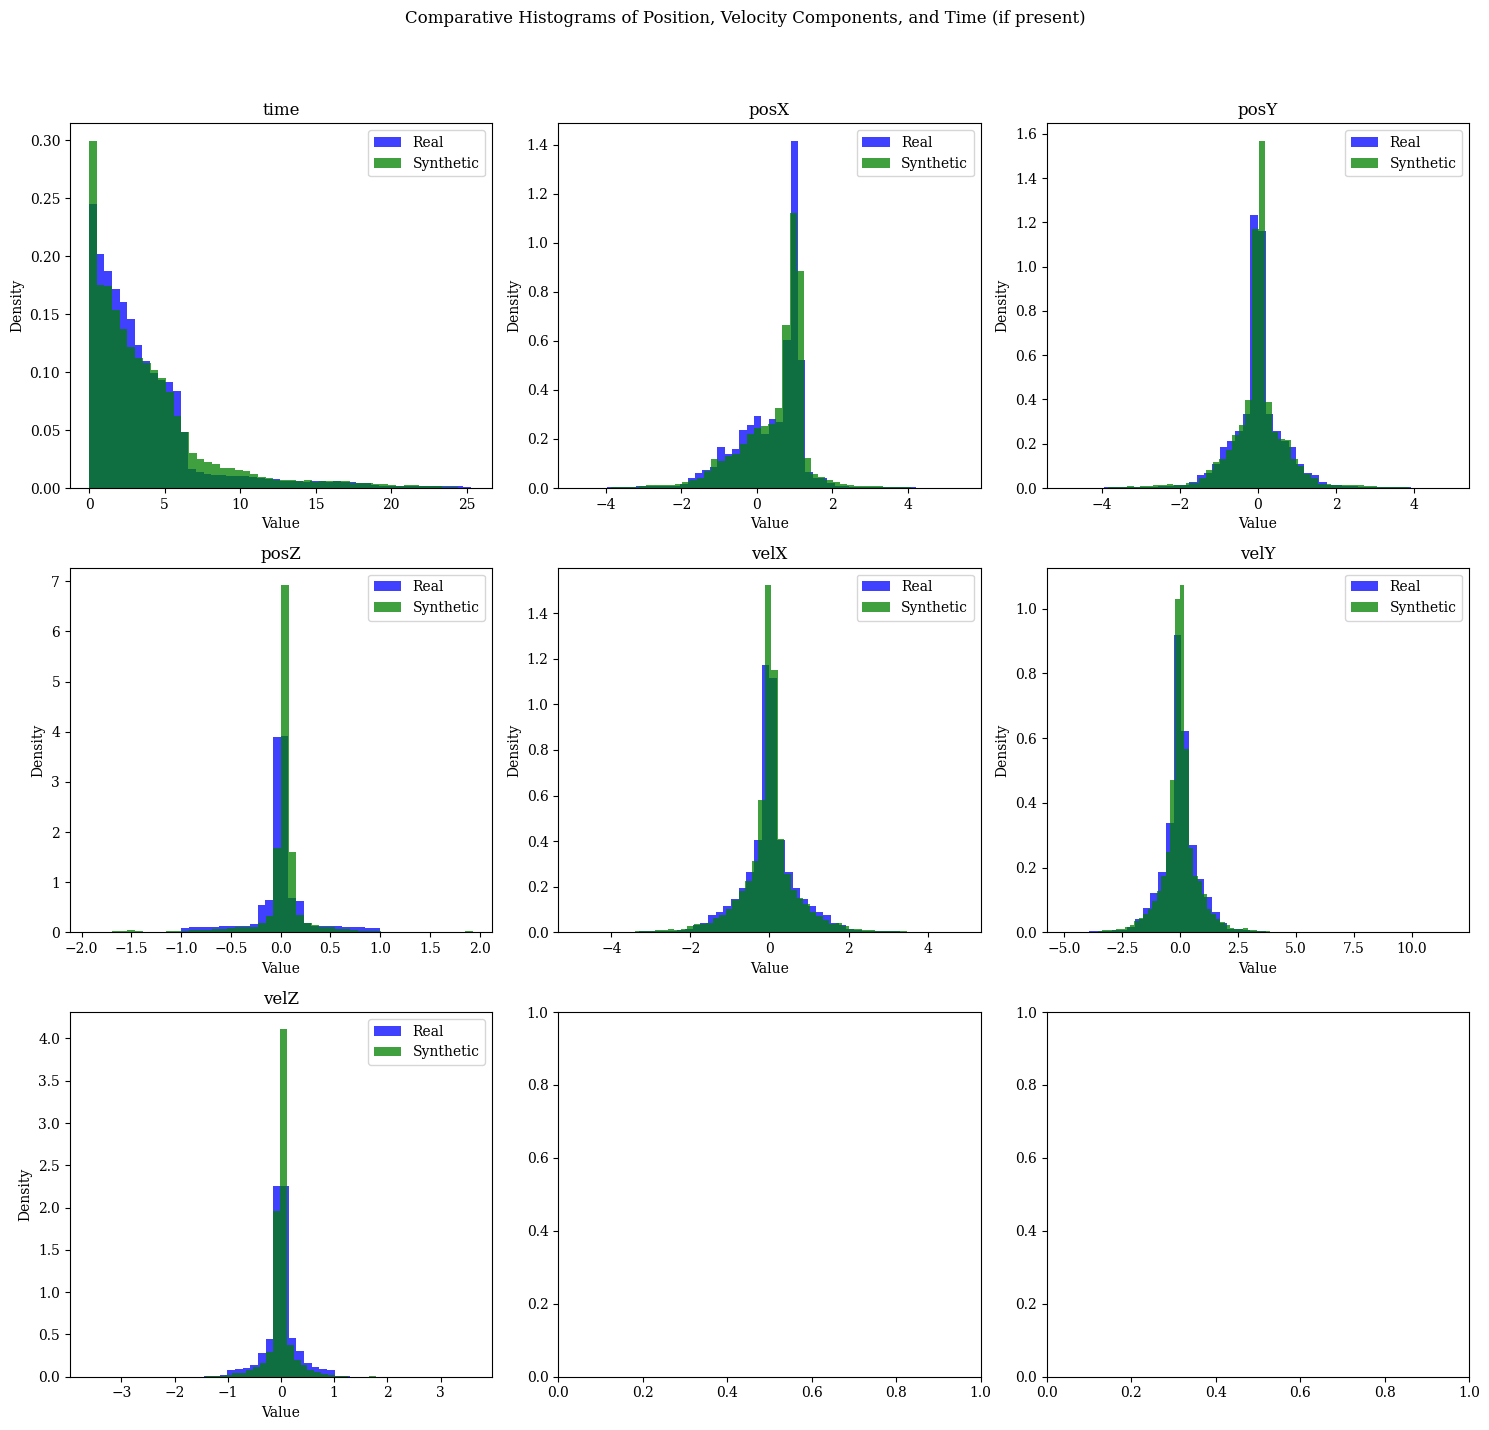

In [69]:
plot_histograms_comparison(data1=full_data, data2=generation, label1='Real', label2='Synthetic', normalize=True, save_path=full_histogram_comparison_path)

## Pheasibility

In [70]:
if calculate_error_metrics:

    #Order metrics
    reordered_generation, order_metrics_array, order_metric_labels = reorder_orbits(generation)
    average_order_metrics = order_metrics_array.mean(axis=0)
    average_order_metrics_dict = dict(zip(order_metric_labels, average_order_metrics))

    # Pheasibility metrics
    per_orbit_errors = calculate_errors_per_orbit(reordered_generation,EM_MU)
    mean_errors = {key: np.mean(value) for key, value in per_orbit_errors.items()}
    generation_df = pd.DataFrame(per_orbit_errors)
    new_values_df = pd.DataFrame(order_metrics_array, columns=order_metric_labels)
    generation_df = pd.concat([generation_df, new_values_df], axis=1)

    add_experiment_metrics(experiments_folder, params=params, metrics={**mean_errors, **average_order_metrics_dict})

else:
    generation_df = pd.read_csv(generation_df_path)



Metrics added to experiment with ID 23 in ../experiments/experiments.json.


In [71]:
generation_df.head()

position_error  velocity_error  energy_error  disorder_metric  \
0        0.204775        0.684061      4.716598             28.0   
1        0.122976        0.378417     10.013033             92.0   
2        0.155926        0.270953      9.231605             98.0   
3        0.044715        0.117407      0.083543            142.0   
4        0.064736        0.194818      0.124165            356.0   

   correct_order  inversions  kendall_tau_distance  
0           89.0        14.0              0.005689  
1           74.0        51.0              0.020694  
2           70.0        56.0              0.022695  
3           60.0        87.0              0.035351  
4           62.0       222.0              0.093183

# Convergence

In [82]:
generation[10][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.35430297, 0.66175586,
       0.6579219 , 0.951644  , 0.61422676, 1.5267383 , 0.9258633 ,
       0.946182  , 1.289556  , 0.9647553 , 1.5702287 , 1.4983407 ,
       1.8371278 , 1.5488257 , 2.2794545 , 2.1275885 , 1.9262259 ,
       1.9881891 , 2.2014804 , 2.242813  , 2.3728082 , 2.4963076 ,
       2.7137873 , 2.6437294 , 2.8529105 , 2.9080381 , 2.9511983 ,
       2.9361339 , 3.1657705 , 3.3201199 , 3.5208883 , 3.4242983 ,
       3.3167882 , 3.536119  , 3.7265372 , 3.8132842 , 4.179331  ,
       4.040418  , 4.223544  , 4.580615  , 4.4775634 , 4.486459  ,
       4.705276  , 4.930344  , 4.92492   , 5.3521395 , 5.205718  ,
       5.092626  , 5.645857  , 5.3733196 , 5.520732  , 5.930923  ,
       5.968035  , 6.218754  , 5.746056  , 6.0040755 , 6.270777  ,
       6.781422  , 6.2198644 , 6.646246  , 6.995035  , 6.7392936 ,
       6.6323347 , 7.115579  , 7.121963  , 7.288949  , 7.15176

In [81]:
reordered_generation[10][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.35430297, 0.61422676,
       0.6579219 , 0.66175586, 0.9258633 , 0.946182  , 0.951644  ,
       0.9647553 , 1.289556  , 1.4983407 , 1.5267383 , 1.5488257 ,
       1.5702287 , 1.8371278 , 1.9262259 , 1.9881891 , 2.1275885 ,
       2.2014804 , 2.242813  , 2.2794545 , 2.3728082 , 2.4963076 ,
       2.6437294 , 2.7137873 , 2.8529105 , 2.9080381 , 2.9361339 ,
       2.9511983 , 3.1657705 , 3.3167882 , 3.3201199 , 3.4242983 ,
       3.5208883 , 3.536119  , 3.7265372 , 3.8132842 , 4.040418  ,
       4.179331  , 4.223544  , 4.4775634 , 4.486459  , 4.580615  ,
       4.705276  , 4.92492   , 4.930344  , 5.092626  , 5.205718  ,
       5.3521395 , 5.3733196 , 5.520732  , 5.645857  , 5.746056  ,
       5.930923  , 5.968035  , 6.0040755 , 6.218754  , 6.2198644 ,
       6.270777  , 6.6323347 , 6.646246  , 6.7392936 , 6.781422  ,
       6.995035  , 7.115579  , 7.121963  , 7.151766  , 7.26235

In [ ]:
if want_to_perform_convergence:
    refined_orbits, refined_orbits_df= process_diferential_correction_orbits(np.transpose(reordered_generation,(0,2,1)),
                                                                        EM_MU,
                                                                        max_iter=params['max_iter_convergence'])
    refined_orbits = np.transpose(refined_orbits,(0,2,1))
    np.save(refined_data_path, refined_orbits)
else:
    refined_orbits = np.load(refined_data_path)
    refined_orbits_df = pd.read_csv(refined_orbits_df_path)

refined_orbits.shape

Order Metrics

In [73]:
# Order orbits and average metrics
reordered_refined_orbits, refined_order_metrics_array, refined_order_metric_labels = reorder_orbits(refined_orbits)
refined_average_order_metrics = refined_order_metrics_array.mean(axis=0)
refined_order_metrics = dict(zip(refined_order_metric_labels, refined_average_order_metrics))

# Add individual metrics to the df
new_values_df = pd.DataFrame(refined_order_metrics_array, columns=refined_order_metric_labels)
refined_orbits_df = pd.concat([refined_orbits_df, new_values_df], axis=1)

refined_order_metrics

/tmp/ipykernel_1601293/457979809.py:3: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.10/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning:

invalid value encountered in divide



{'disorder_metric': np.float64(nan),
 'correct_order': np.float64(nan),
 'inversions': np.float64(nan),
 'kendall_tau_distance': np.float64(nan)}

Pheasibility Metrics

In [74]:
refined_per_orbit_errors = calculate_errors_per_orbit(reordered_refined_orbits,EM_MU)
refined_orbits_df['propagated_position_error'] = refined_per_orbit_errors['position_error']
refined_orbits_df['propagated_velocity_error'] = refined_per_orbit_errors['velocity_error']
refined_orbits_df['propagated_energy_error'] = refined_per_orbit_errors['energy_error']
refined_mean_errors = {key: np.mean(value) for key, value in refined_per_orbit_errors.items()}
refined_mean_errors

/usr/local/lib/python3.10/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.10/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning:

invalid value encountered in scalar divide



{'position_error': np.float64(nan),
 'velocity_error': np.float64(nan),
 'energy_error': np.float64(nan)}

In [75]:
refined_orbits_df.head()

Empty DataFrame
Columns: [id, old_period, new_period, iterations_convergence, error, initial_pos_x0, initial_pos_y0, initial_pos_z0, initial_vel_x0, initial_vel_y0, initial_vel_z0, final_pos_x0, final_pos_y0, final_pos_z0, final_vel_x0, final_vel_y0, final_vel_z0, disorder_metric, correct_order, inversions, kendall_tau_distance, propagated_position_error, propagated_velocity_error, propagated_energy_error]
Index: []

In [76]:
refined_ids = refined_orbits_df['id'].astype(int).tolist()
generated_data_that_was_refined = generation[refined_ids]
generated_data_that_was_refined.shape

(0, 7, 100)

## Visualization

Generation that was able to get Refined

ValueError: zero-size array to reduction operation minimum which has no identity

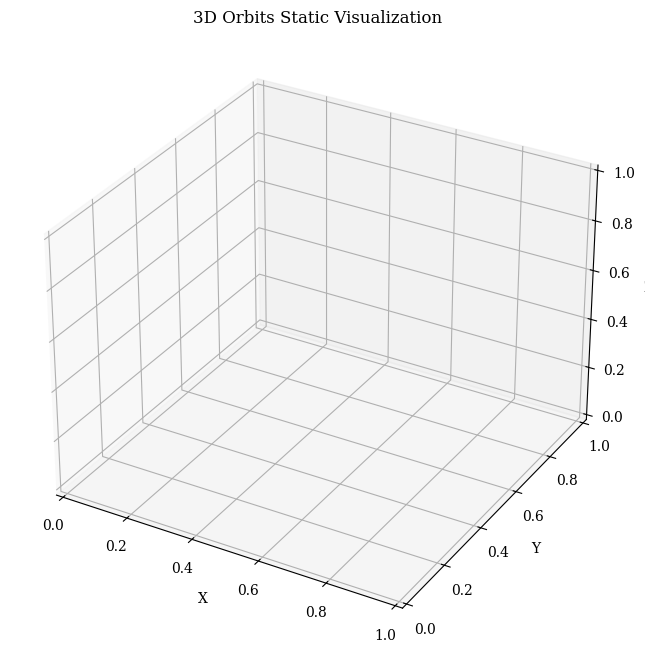

In [77]:
visualize_static_orbits(generated_data_that_was_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_converged_path)

Refinement

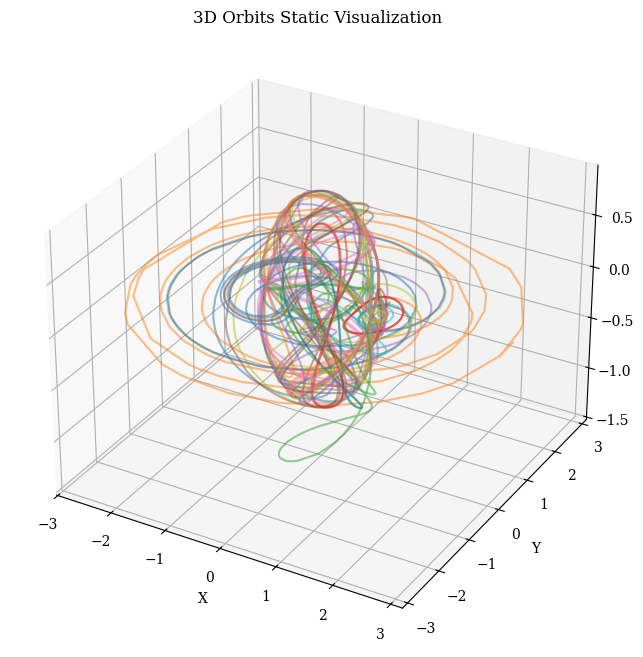

In [ ]:
visualize_static_orbits(reordered_refined_orbits[:,1:,:], show_legend=False, save_path=refined_orbits_path)

Generation that didn't manage to get refined

In [ ]:
non_refined_ids = sorted(set(range(params['samples_to_generate'])) - set(refined_ids))
generated_data_that_was_not_refined = generation[non_refined_ids]
generated_data_that_was_not_refined.shape

(55, 7, 100)

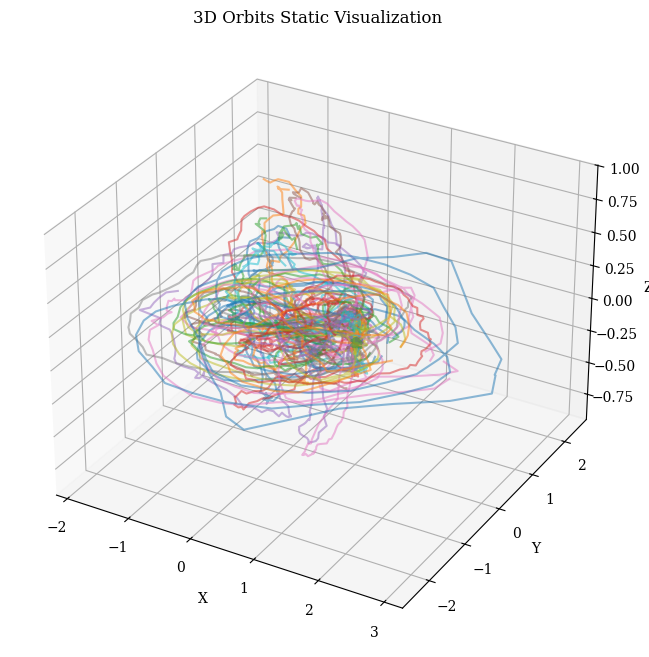

In [ ]:
visualize_static_orbits(generated_data_that_was_not_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_did_not_converged_path)

## Latent Space

In [ ]:
refined_scaled_data = scaler.transform(torch.from_numpy(refined_orbits).float())
refined_latent_means, refined_latent_log_vars = model.encode(refined_scaled_data)
refined_latent_means = refined_latent_means.detach().numpy()
refined_latent_log_vars = refined_latent_log_vars.detach().numpy()
refined_latent_representations = np.concatenate((refined_latent_means, refined_latent_log_vars), axis=1)
refined_latent_representations.shape

(63, 4)

Saved plot to ../experiments/experiment_19/images/exp19_combined_latent_space


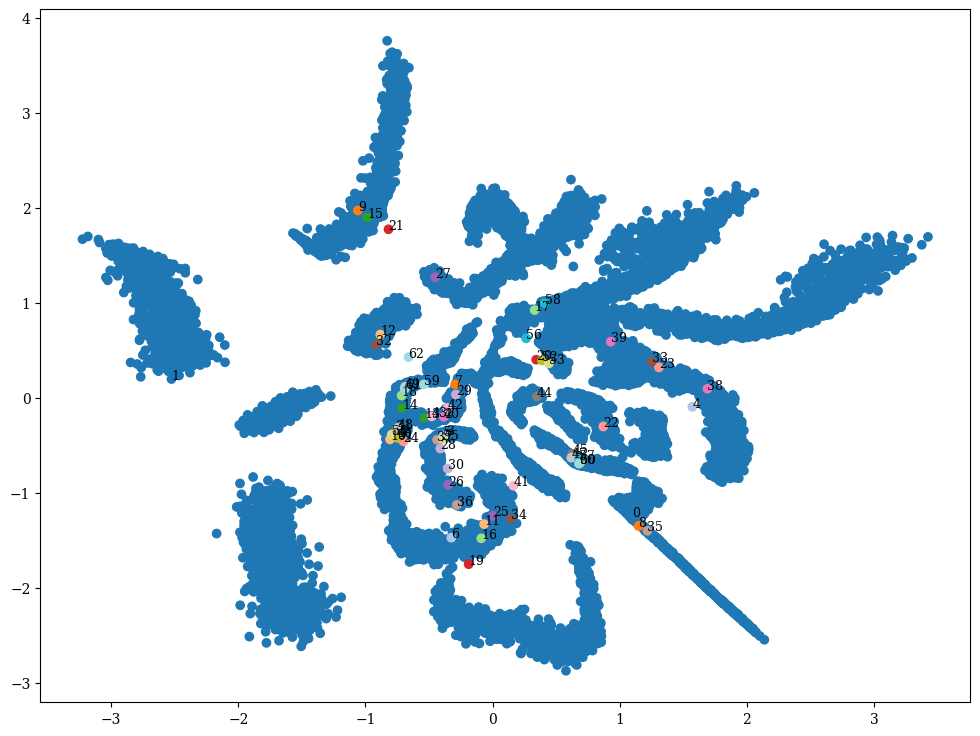

In [ ]:
if refined_latent_means.shape[1]>2:
    rls=reduce_dimensions_latent_space(train_latent=latent_representation,
                                        val_latent=refined_latent_means)
    latent_representation=rls['PCA']['train']
    refined_latent_means=rls['PCA']['val']

plot_combined_2d_latent_space(
    real_latent=latent_means, 
    synthetic_latent=refined_latent_means,
    synthetic_labels=list(range(0, len(refined_scaled_data))),
    annotation_mode='numbers',
    save_path=combined_latent_space_path
)

In [ ]:
scaled_generation = scaler.transform(torch.from_numpy(generation).float())
latent_generation_means, _ = model.encode(scaled_generation)
latent_generation_means = latent_generation_means.detach().numpy()
latent_generation_means_that_refined = latent_generation_means[refined_ids]
generation_to_refinement = np.stack((latent_generation_means_that_refined, refined_latent_means), axis=1)
generation_to_refinement.shape

(63, 2, 2)

Saved plot to ../experiments/experiment_19/images/exp19_combined_latent_space_arrows


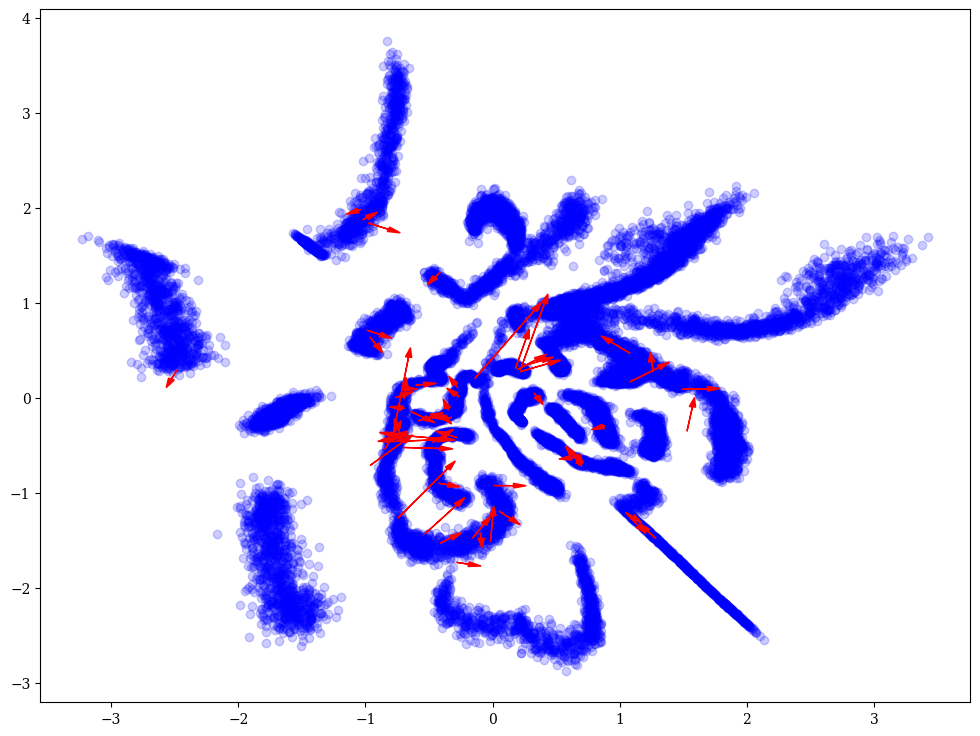

In [ ]:
plot_combined_2d_latent_space(
    real_latent=latent_means, 
    synthetic_latent=generation_to_refinement,
    annotation_mode='numbers',
    save_path=combined_latent_space_arrows_path
)

In [ ]:
generation_to_refinement_latent_distance = calculate_pairwise_distances(latent_generation_means_that_refined, refined_latent_means, distance_metric=params['distance_metric'])
refined_orbits_df['latent_distance_to_generation'] = generation_to_refinement_latent_distance

## Features

Calculate Jacobi Constant on the dataset

In [ ]:
results = np.array([jacobi_constant(np.transpose(full_data[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(full_data.shape[0])])
full_orbit_df['calculated_jacobi'] = results

full_orbit_df.head()

id_class       x_0           y_0       x_0          vx_0      vy_0  \
0       1.0  0.941000  1.900442e-23  0.509474  2.968938e-13 -0.124968   
1       1.0  0.941538 -8.592698e-24  0.508602  2.902340e-13 -0.125672   
2       1.0  0.942076  6.956604e-24  0.507729  2.685527e-13 -0.126375   
3       1.0  0.942613  1.763946e-24  0.506856  3.153637e-13 -0.127078   
4       1.0  0.943150  9.441804e-24  0.505982  2.663322e-13 -0.127781   

           vz_0    jacobi     period   stability  propagated_periods  \
0 -3.122717e-12  2.745412  11.555291  211.184678                 3.0   
1 -3.252212e-12  2.746226  11.551622  210.329145                 3.0   
2 -2.862050e-12  2.747039  11.547936  209.473685                 3.0   
3 -3.791054e-12  2.747850  11.544233  208.618315                 3.0   
4 -2.982720e-12  2.748660  11.540511  207.763051                 3.0   

   calculated_jacobi  
0           2.757415  
1           2.758229  
2           2.759042  
3           2.759853  
4           2.760663

Calculate Jacobi Constant and Period on the Refined Orbits

In [ ]:
new_jacobis = np.array([jacobi_constant(np.transpose(refined_orbits[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(refined_orbits.shape[0])])
refined_orbits_df['calculated_jacobi'] = new_jacobis
refined_orbits_df.rename(columns={'new_period': 'period'}, inplace=True)
refined_orbits_df['period_distance_with_generation'] = abs(refined_orbits_df['period'] - refined_orbits_df['old_period'])
refined_orbits_df.head()

id  old_period     period  iterations_convergence         error  \
0   0    7.061340   6.263865                      11  2.780464e-10   
1   1   23.515223  25.147499                       9  6.577028e-11   
2   2    6.236923   6.277323                       8  4.241254e-14   
3   5    6.461202   6.299770                      10  1.326372e-10   
4   6    6.694317   6.259644                      17  3.701905e-10   

   initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
0       -1.743520        0.456197        0.043516        0.522113   
1        3.442655       -0.478886        0.003062       -0.429920   
2        0.720810       -0.207183        0.078186        0.131898   
3        0.662986       -0.578748        0.319790       -0.404583   
4       -0.064609        0.495135       -0.002358       -0.534840   

   initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
0        1.549378        0.273392     -1.719843      0.267656  5.885773e-02   
1       -3.157219        0.007763      3.204238     -0.120580  3.396135e-11   
2        0.254732       -0.660226      0.531337     -0.421758  8.954270e-02   
3       -0.457612       -0.773020      0.706589     -0.554102  4.264464e-01   
4        0.799178        0.018464      0.160355      0.265973  1.862672e-19   

   final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
0      0.315967      1.694703  3.768447e-01            132.0           71.0   
1     -0.103856     -2.728078 -2.007589e-12             44.0           85.0   
2      0.289855     -0.029737 -1.049312e+00             78.0           78.0   
3     -0.033152     -0.689079 -8.496252e-01            134.0           78.0   
4     -0.873348      1.819699 -3.252832e-18            186.0           73.0   

   inversions  kendall_tau_distance  propagated_position_error  \
0        81.0              0.032727               2.523440e-12   
1        26.0              0.010505               5.834723e-12   
2        46.0              0.018586               1.151644e-12   
3        86.0              0.034747               3.074261e-12   
4       117.0              0.047273               2.195234e-12   

   propagated_velocity_error  propagated_energy_error  \
0               8.365287e-12             2.637126e-11   
1               5.975832e-12             9.727451e-12   
2               1.947498e-12             1.314773e-14   
3               8.590032e-12             2.649418e-11   
4               9.882295e-12             3.093714e-12   

   latent_distance_to_generation  calculated_jacobi  \
0                       0.050364           1.078889   
1                       0.099810           3.465267   
2                       0.055051           2.172838   
3                       0.084720           1.623067   
4                       0.258395           2.294519   

   period_distance_with_generation  
0                         0.797475  
1                         1.632277  
2                         0.040400  
3                         0.161432  
4                         0.434673

Compare Features between Dataset and Refinement

Saved plot to ../experiments/experiment_19/images/exp19_features


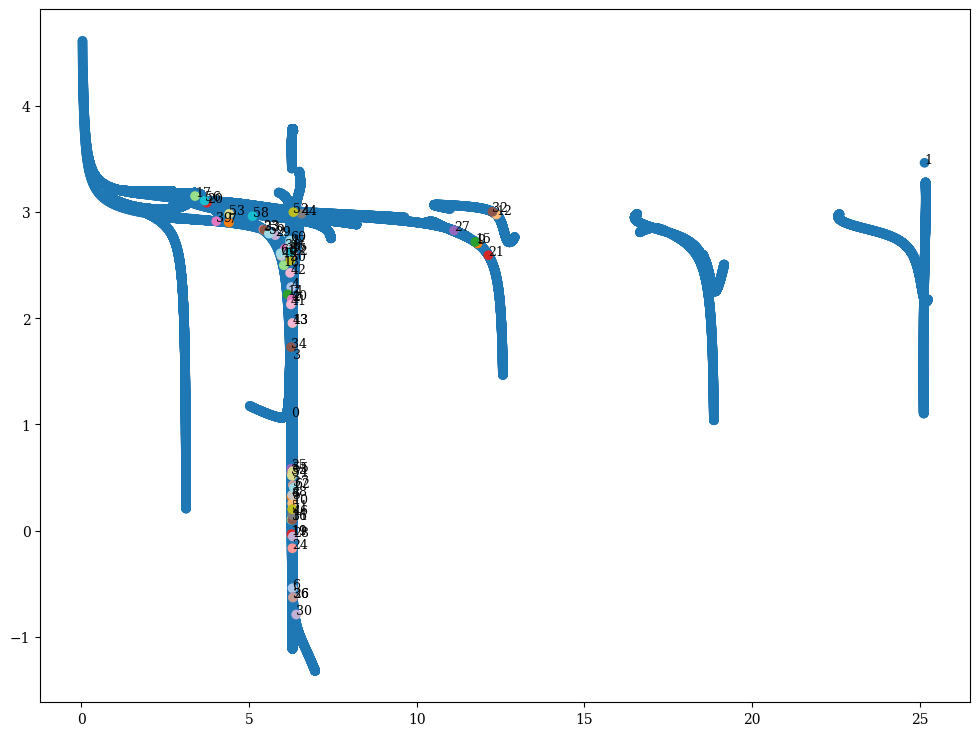

In [ ]:
features_used = ['period', 'calculated_jacobi']

dataset_features = full_orbit_df[features_used].values
refined_orbits_features = refined_orbits_df[features_used].values 

closest_feature_indices, feature_distances = find_nearest_points_batch(refined_orbits_features, dataset_features,
                                                                       n=1, distance_metric=params['distance_metric'])

refined_orbits_df['feature_closest_orbit'] = closest_feature_indices
refined_orbits_df['feature_distance_from_closest_orbit'] = feature_distances

plot_combined_2d_latent_space(dataset_features, refined_orbits_features,
                              synthetic_labels=list(range(0, len(refined_scaled_data))),
                              annotation_mode='numbers', save_path=features_plot_path)

Feature Centroids

In [ ]:
array_features = full_orbit_df[features_used].to_numpy()
feature_centroid = full_orbit_df[features_used].mean().to_numpy()
feature_centroids = compute_centroids(array_features, full_orbits_id_classes, method='mean')
feature_centroids.shape

(40, 2)

In [ ]:
stdev_feature_centroids  = full_orbit_df.groupby('id_class')[features_used].std().values
stdev_feature_centroids.shape

(40, 2)

In [ ]:
feature_centroid = full_orbit_df[features_used].mean().values
feature_centroid.shape

(2,)

In [ ]:
full_unique_classes = list(set(full_orbits_id_classes))
full_family_names=get_orbit_classes(full_unique_classes)[0]
len(full_family_names)

40

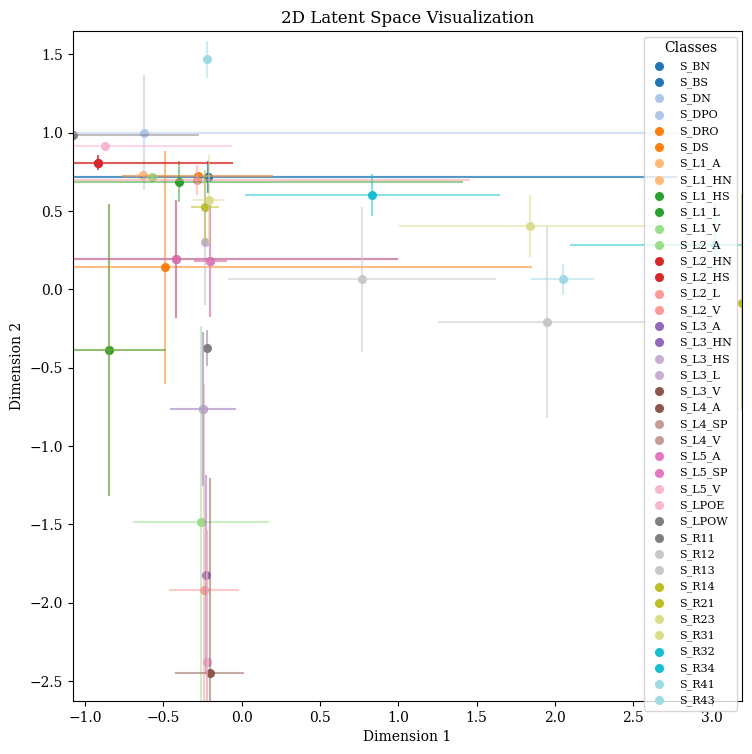

In [ ]:
if len(features_used)==2:
    plot_2d_latent_space(feature_centroids,np.array(full_family_names), latent_stdevs=stdev_feature_centroids, save_path=family_feature_centroids_plot_path)

## Calculate distances

In [ ]:
if data.shape[1] == 7:
    no_time_data = full_data[:,1:,:]
    no_time_refined_orbits = refined_orbits[:,1:,:]
    no_time_generated_data_that_was_refined = generated_data_that_was_refined[:,1:,:]
else:
    no_time_data = full_data
    no_time_refined_orbits = refined_orbits
    no_time_generated_data_that_was_refined = generated_data_that_was_refined

print(no_time_data.shape)
print(no_time_refined_orbits.shape)
print(no_time_generated_data_that_was_refined.shape)
print(no_time_generation.shape)


(45211, 6, 100)
(63, 6, 100)
(63, 6, 100)
(200, 6, 100)


### Orbit Distances

1. Nearest Orbit

In [ ]:
nearest_indices_generation, nearest_distances_generation = find_nearest_orbits_batch(no_time_generation,
                                                                                     no_time_data,
                                                                                     n=1,
                                                                                     distance_metric=params['distance_metric'])
generation_df['nearest_orbit'] = nearest_indices_generation
generation_df['nearest_orbit_distance'] = nearest_distances_generation

In [ ]:
nearest_indices_refined_generation, nearest_distances_refined_generation = find_nearest_orbits_batch(no_time_refined_orbits,
                                                                                                     no_time_data,
                                                                                                     n=1,
                                                                                                     distance_metric=params['distance_metric'])
refined_orbits_df['nearest_orbit'] = nearest_indices_refined_generation
refined_orbits_df['nearest_orbit_distance'] = nearest_distances_refined_generation

2. Generation vs Refinement

In [ ]:
pairwise_distances = calculate_pairwise_orbit_distances(no_time_generated_data_that_was_refined,
                                                        no_time_refined_orbits, distance_metric=params['distance_metric'])
refined_orbits_df['distance_from_generation'] = pairwise_distances

### Point Distances

3. Distance from the centre

In [ ]:
# Latent space distance
centroid_distances = calculate_distances_batch(full_data_centroid, refined_latent_means, distance_metric=params['distance_metric'])
refined_orbits_df['centroid_distance'] = centroid_distances

In [ ]:
# Feature distance
feature_centroid_distances = calculate_distances_batch(feature_centroid, refined_orbits_features, distance_metric=params['distance_metric'])
refined_orbits_df['feature_centroid_distance'] = feature_centroid_distances

4. Distance from centroids

In [ ]:
# Latent Space Centroids
closest_family_centroid, closest_family_centroid_distance = find_nearest_points_batch(refined_latent_means, centroid_means, n=1, distance_metric=params['distance_metric'])
refined_orbits_df['closest_family_centroid'] = closest_family_centroid
refined_orbits_df['closest_family_centroid_distance'] = closest_family_centroid_distance

In [ ]:
# Feature Space Centroids
closest_family_feature_centroid, closest_family_feature_centroid_distance = find_nearest_points_batch(refined_orbits_features, feature_centroids, n=1, distance_metric=params['distance_metric'])
refined_orbits_df['closest_family_feature_centroid'] = closest_family_feature_centroid
refined_orbits_df['closest_family_feature_centroid_distance'] = closest_family_feature_centroid_distance

5. Initial Conditions

In [ ]:
# Extract initial and final conditions
initial_conditions = refined_orbits_df[['initial_pos_x0', 'initial_pos_y0', 'initial_pos_z0',
                        'initial_vel_x0', 'initial_vel_y0', 'initial_vel_z0']].values
final_conditions = refined_orbits_df[['final_pos_x0', 'final_pos_y0', 'final_pos_z0',
                      'final_vel_x0', 'final_vel_y0', 'final_vel_z0']].values

ics_distances = calculate_pairwise_distances(initial_conditions, final_conditions, distance_metric=params['distance_metric'])
refined_orbits_df['initial_conditions_distance'] = ics_distances

## Export Features

In [ ]:
generation_df.to_csv(generation_df_path, index=False)
generation_df.shape

(200, 9)

In [ ]:
generation_df.head()

position_error  velocity_error  energy_error  disorder_metric  \
0        0.231801        0.395650      0.442458            164.0   
1        0.642518        0.578454      0.581627             74.0   
2        0.105508        0.151281      0.533362             96.0   
3        0.424801        0.647656      0.741195            138.0   
4        0.063929        0.151872      0.128629            184.0   

   correct_order  inversions  kendall_tau_distance  nearest_orbit  \
0           71.0       105.0              0.042424          19941   
1           82.0        44.0              0.017778          37891   
2           77.0        62.0              0.025051          28082   
3           79.0        90.0              0.036364          44677   
4           71.0       125.0              0.050505           3176   

   nearest_orbit_distance  
0                3.187352  
1                6.677067  
2                2.566815  
3                5.007864  
4                1.834409

In [ ]:
refined_orbits_df.to_csv(refined_orbits_df_path, index=False)
refined_orbits_df.shape

(63, 39)

In [ ]:
refined_orbits_df.head()

id  old_period     period  iterations_convergence         error  \
0   0    7.061340   6.263865                      11  2.780464e-10   
1   1   23.515223  25.147499                       9  6.577028e-11   
2   2    6.236923   6.277323                       8  4.241254e-14   
3   5    6.461202   6.299770                      10  1.326372e-10   
4   6    6.694317   6.259644                      17  3.701905e-10   

   initial_pos_x0  initial_pos_y0  initial_pos_z0  initial_vel_x0  \
0       -1.743520        0.456197        0.043516        0.522113   
1        3.442655       -0.478886        0.003062       -0.429920   
2        0.720810       -0.207183        0.078186        0.131898   
3        0.662986       -0.578748        0.319790       -0.404583   
4       -0.064609        0.495135       -0.002358       -0.534840   

   initial_vel_y0  initial_vel_z0  final_pos_x0  final_pos_y0  final_pos_z0  \
0        1.549378        0.273392     -1.719843      0.267656  5.885773e-02   
1       -3.157219        0.007763      3.204238     -0.120580  3.396135e-11   
2        0.254732       -0.660226      0.531337     -0.421758  8.954270e-02   
3       -0.457612       -0.773020      0.706589     -0.554102  4.264464e-01   
4        0.799178        0.018464      0.160355      0.265973  1.862672e-19   

   final_vel_x0  final_vel_y0  final_vel_z0  disorder_metric  correct_order  \
0      0.315967      1.694703  3.768447e-01            132.0           71.0   
1     -0.103856     -2.728078 -2.007589e-12             44.0           85.0   
2      0.289855     -0.029737 -1.049312e+00             78.0           78.0   
3     -0.033152     -0.689079 -8.496252e-01            134.0           78.0   
4     -0.873348      1.819699 -3.252832e-18            186.0           73.0   

   inversions  kendall_tau_distance  propagated_position_error  \
0        81.0              0.032727               2.523440e-12   
1        26.0              0.010505               5.834723e-12   
2        46.0              0.018586               1.151644e-12   
3        86.0              0.034747               3.074261e-12   
4       117.0              0.047273               2.195234e-12   

   propagated_velocity_error  propagated_energy_error  \
0               8.365287e-12             2.637126e-11   
1               5.975832e-12             9.727451e-12   
2               1.947498e-12             1.314773e-14   
3               8.590032e-12             2.649418e-11   
4               9.882295e-12             3.093714e-12   

   latent_distance_to_generation  calculated_jacobi  \
0                       0.050364           1.078889   
1                       0.099810           3.465267   
2                       0.055051           2.172838   
3                       0.084720           1.623067   
4                       0.258395           2.294519   

   period_distance_with_generation  feature_closest_orbit  \
0                         0.797475                  19914   
1                         1.632277                  37891   
2                         0.040400                  24892   
3                         0.161432                  30916   
4                         0.434673                   5102   

   feature_distance_from_closest_orbit  nearest_orbit  nearest_orbit_distance  \
0                             0.000464          19924                4.395128   
1                             0.186274          37891                9.780718   
2                             0.000573          28077                1.617496   
3                             0.001111          30899                2.811912   
4                             0.000351           5119                4.274598   

   distance_from_generation  centroid_distance  feature_centroid_distance  \
0                  4.887719           1.637371                   1.653750   
1                  8.507388           2.797253                  17.925631   
2                  2.623741           0.746072               

In [ ]:
not_to_show_columns = ['initial_pos_x0','initial_pos_y0','initial_pos_z0',	'initial_vel_x0',	'initial_vel_y0',	'initial_vel_z0	final_pos_x0',	'final_pos_y0',	'final_pos_z0',	'final_vel_x0',	'final_vel_y0',	'final_vel_z0', 'inversions',	'kendall_tau_distance' , 'closest_feature_indices',	'nearest_orbit', 'closest_family_centroid', 'closest_family_feature_centroid']

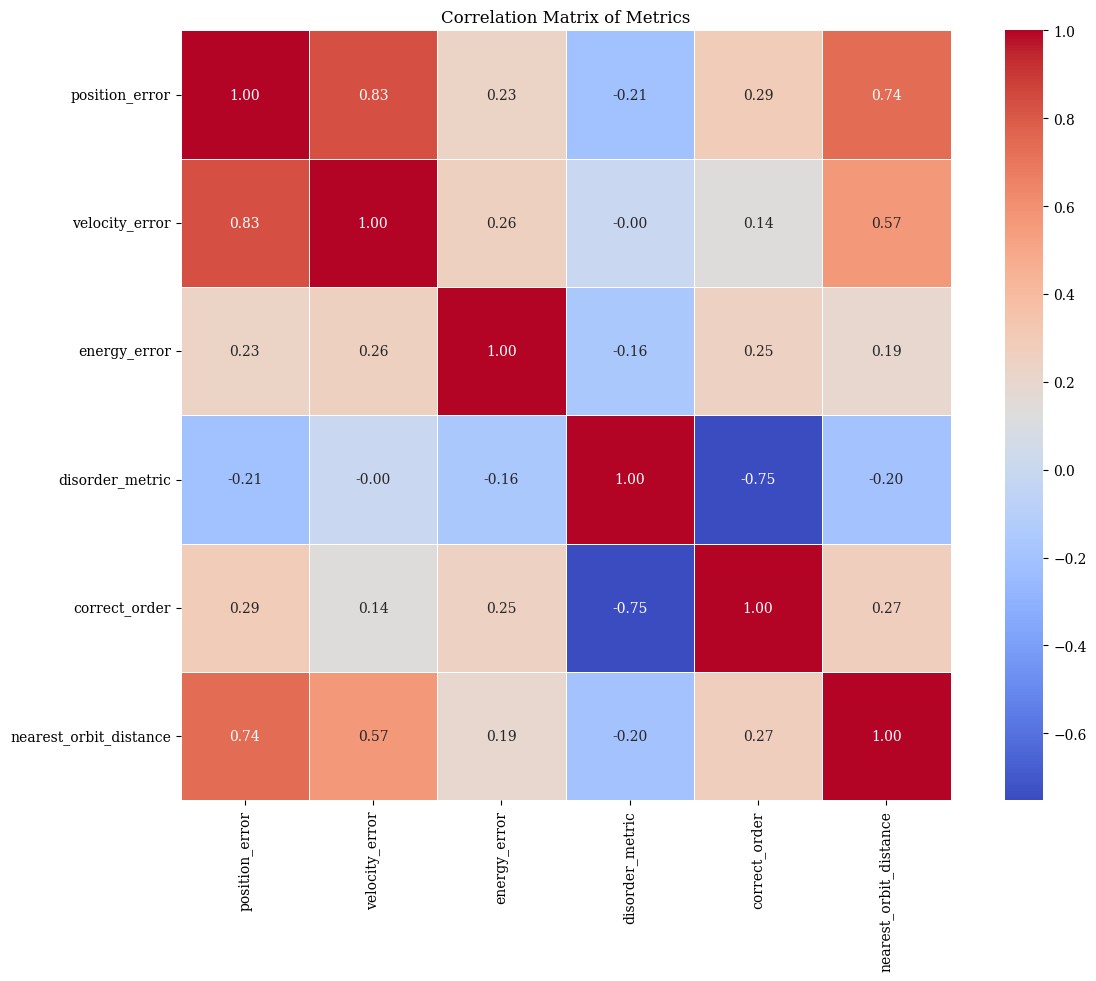

In [ ]:
plot_corr_matrix(generation_df.drop(columns=not_to_show_columns, errors='ignore'))

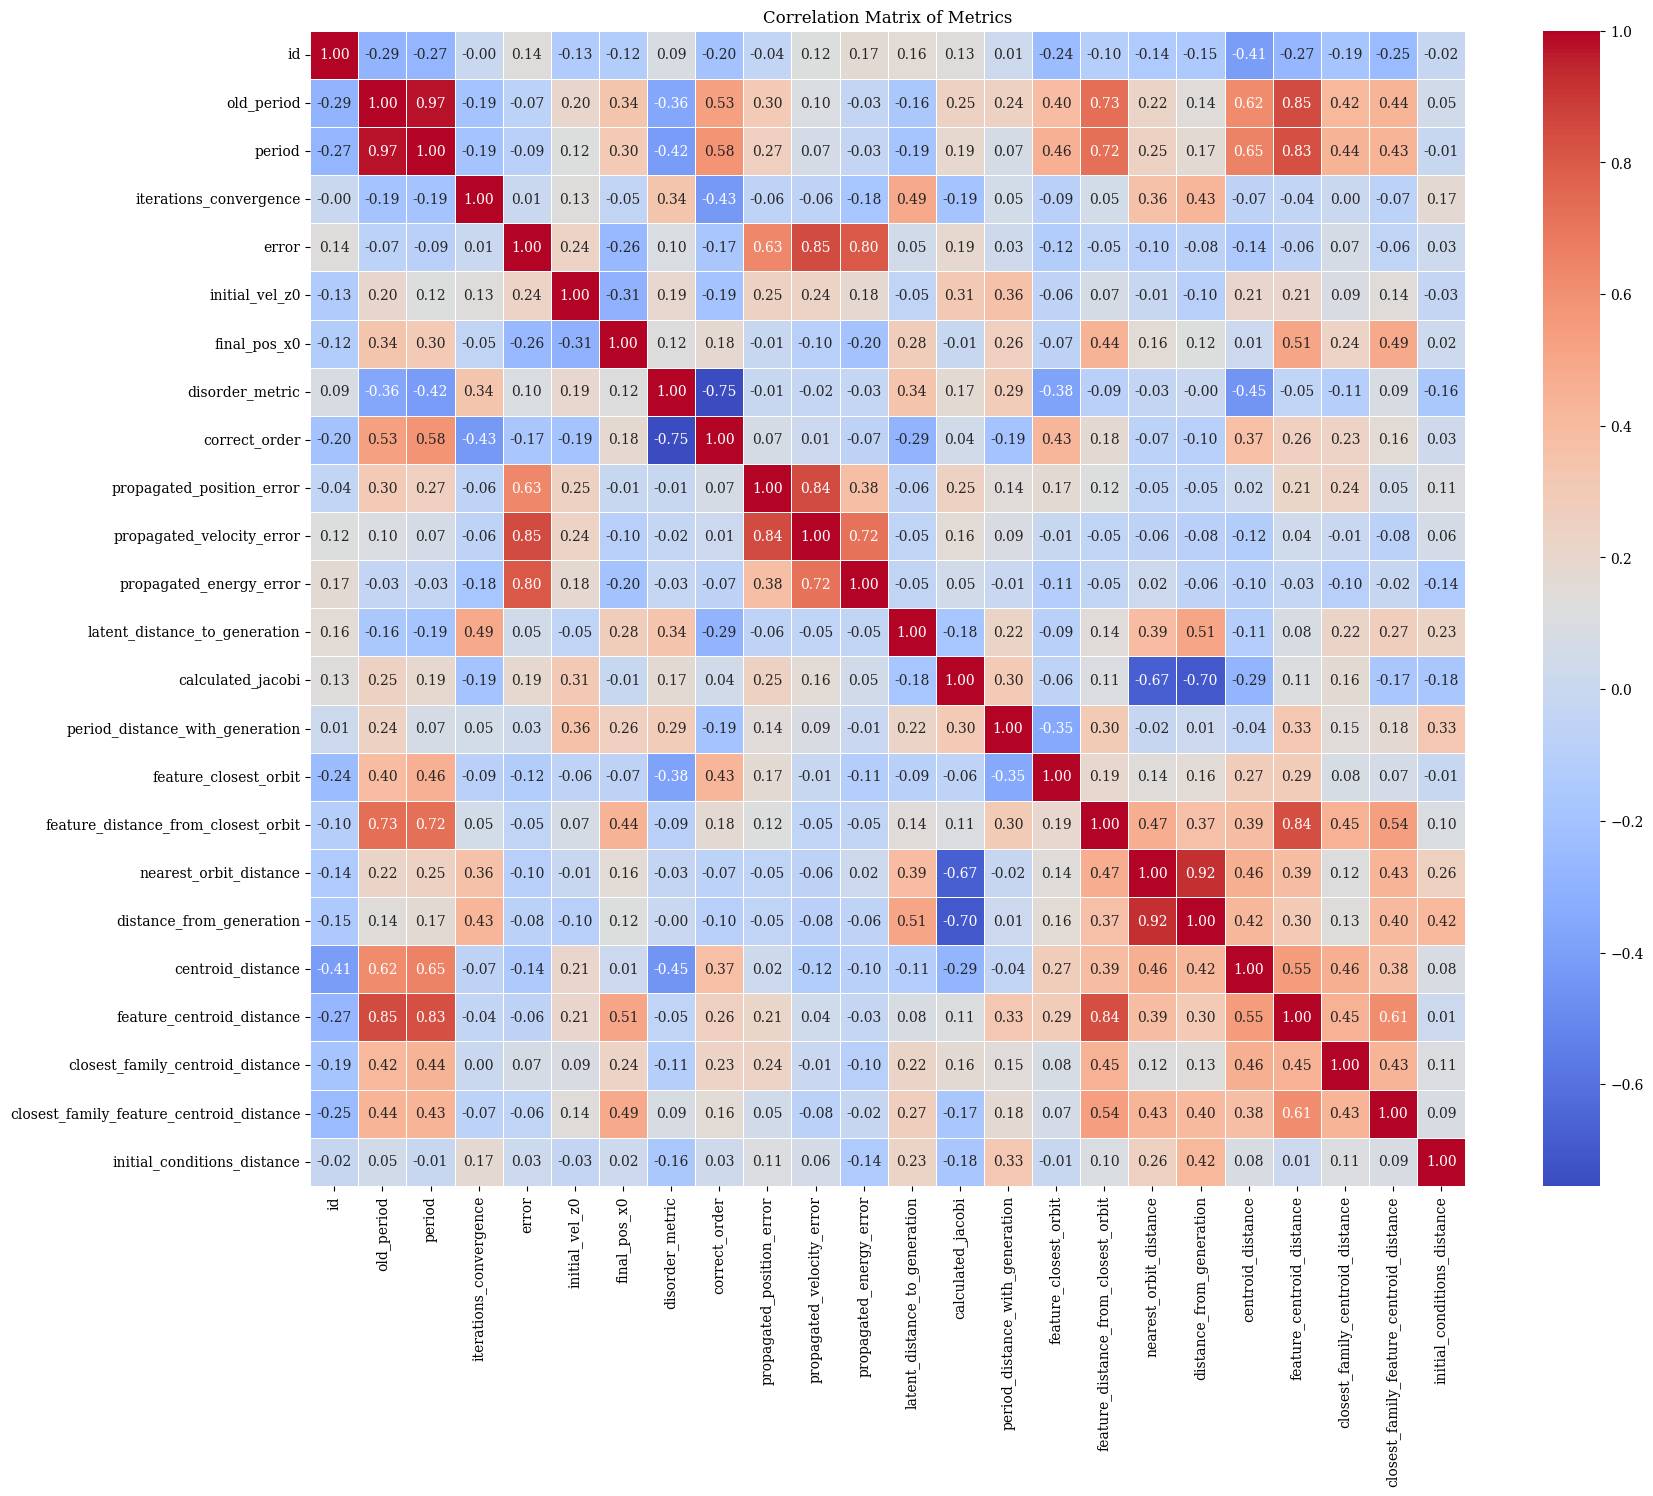

In [ ]:
plot_corr_matrix(refined_orbits_df.drop(columns=not_to_show_columns, errors='ignore'), figsize=(20,15))

# Check Discovery

Calculate Full Centroid Distances

In [ ]:
# Recalculate distance from latent space centroids
closest_family_centroid, closest_family_centroid_distance = find_nearest_points_batch(refined_latent_means, full_centroid_means, n=1, distance_metric=params['distance_metric'])
refined_orbits_df['closest_family_full_centroid'] = closest_family_centroid
refined_orbits_df['closest_family_full_centroid_distance'] = closest_family_centroid_distance

In [ ]:
family_mapping = full_orbit_df['id_class'].to_dict()

def get_class_name(orbit_id):
    return family_mapping.get(orbit_id, None)

refined_orbits_df['family_of_feature_closest_orbit'] = refined_orbits_df['feature_closest_orbit'].apply(get_class_name)
refined_orbits_df['family_of_closest_orbit'] = refined_orbits_df['nearest_orbit'].apply(get_class_name)
refined_orbits_df.to_csv(refined_orbits_df_path, index=False)
refined_orbits_df.shape

(63, 43)

In [ ]:
family_columns = ['family_of_feature_closest_orbit', 'family_of_closest_orbit', 'closest_family_feature_centroid','closest_family_full_centroid']
filter_condition = refined_orbits_df[family_columns].isin(discarded_family_ids).any(axis=1)
close_discovery_df = refined_orbits_df[filter_condition]
close_discovery_df.shape

(31, 43)

In [ ]:
close_discovery_df[family_columns].head()

family_of_feature_closest_orbit  family_of_closest_orbit  \
0                             17.0                     17.0   
2                             22.0                     26.0   
3                             29.0                     29.0   
7                             22.0                     26.0   
8                             17.0                     17.0   

   closest_family_feature_centroid  closest_family_full_centroid  
0                               10                            16  
2                               29                            24  
3                               18                            26  
7                               11                            24  
8                               26                            16

In [ ]:
filter_condition = refined_orbits_df[['family_of_feature_closest_orbit', 'family_of_closest_orbit']].isin(discarded_family_ids).any(axis=1)
discovery_df = refined_orbits_df[filter_condition]
discovery_df.shape

(9, 43)

In [ ]:
family_orbit_columns = ['id','feature_closest_orbit', 'nearest_orbit', 'family_of_feature_closest_orbit', 'family_of_closest_orbit', 'closest_family_feature_centroid','closest_family_full_centroid']
discovery_df[family_orbit_columns]

id  feature_closest_orbit  nearest_orbit  \
2     2                  24892          28077   
7    13                  25345          28545   
13   34                  24649          27867   
17   42                  15248          17969   
39   85                  25373           5432   
40   88                  24895          28088   
42   90                  25013          28197   
43   95                  24660          27884   
56  167                   1064          18053   

    family_of_feature_closest_orbit  family_of_closest_orbit  \
2                              22.0                     26.0   
7                              22.0                     26.0   
13                             22.0                     26.0   
17                             13.0                     15.0   
39                             22.0                      5.0   
40                             22.0                     26.0   
42                             22.0                     26.0   
43                             22.0                     26.0   
56                              1.0                     15.0   

    closest_family_feature_centroid  closest_family_full_centroid  
2                                29                            24  
7                                11                            24  
13                               29                            10  
17                                6                            12  
39                                6                            14  
40                               29                            24  
42                               25                            24  
43                               29                            24  
56                                6                             6

In [ ]:
### check which sample

In [ ]:
discarded_family_ids

[18.0, 1.0, 19.0, 16.0, 34.0, 24.0, 9.0, 22.0, 37.0, 13.0]

In [ ]:
refinement_indexes = discovery_df.index.to_list()
feature_closest_orbit_indexes = discovery_df['feature_closest_orbit'].to_list()
nearest_orbit_indexes = discovery_df['nearest_orbit'].to_list()

discovery_refinement = reordered_refined_orbits[refinement_indexes]
feature_closest_orbits = full_data[feature_closest_orbit_indexes]
nearest_orbits = full_data[nearest_orbit_indexes]

(9, 7, 100)

In [ ]:
refinement_and_closers = np.stack(
    (discovery_refinement, feature_closest_orbits, nearest_orbits),
    axis=1
)
refinement_and_closers.shape

(9, 3, 7, 100)

## Visualize

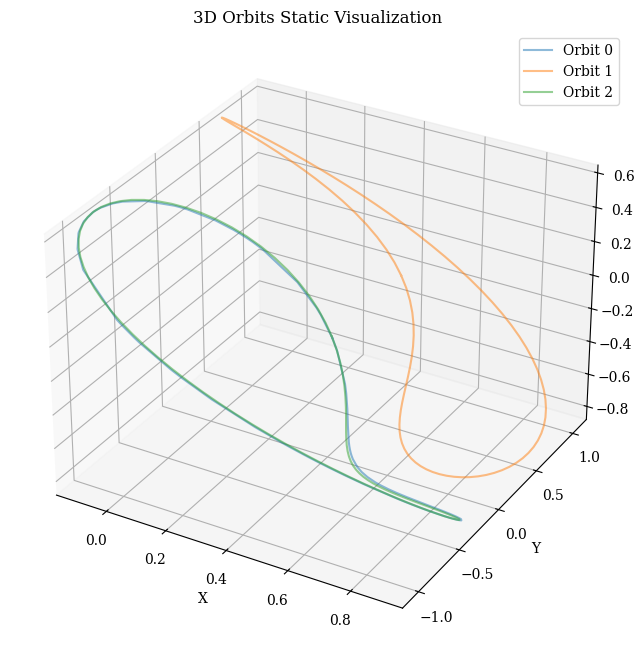

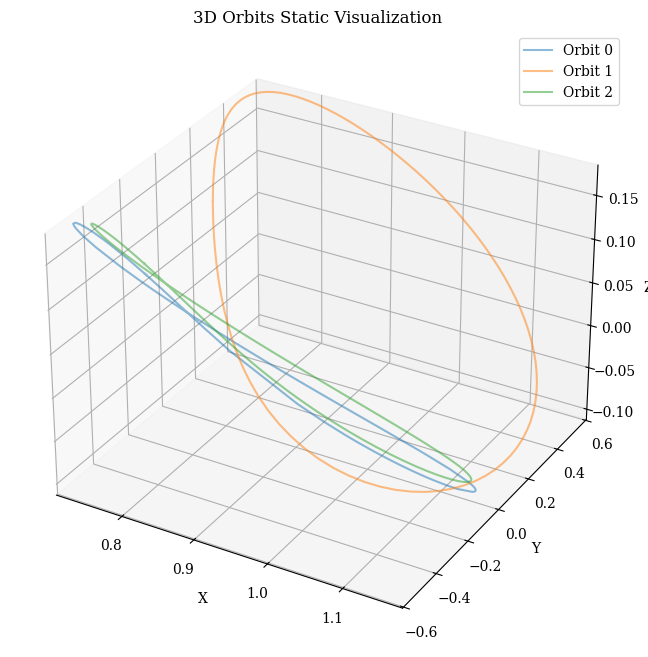

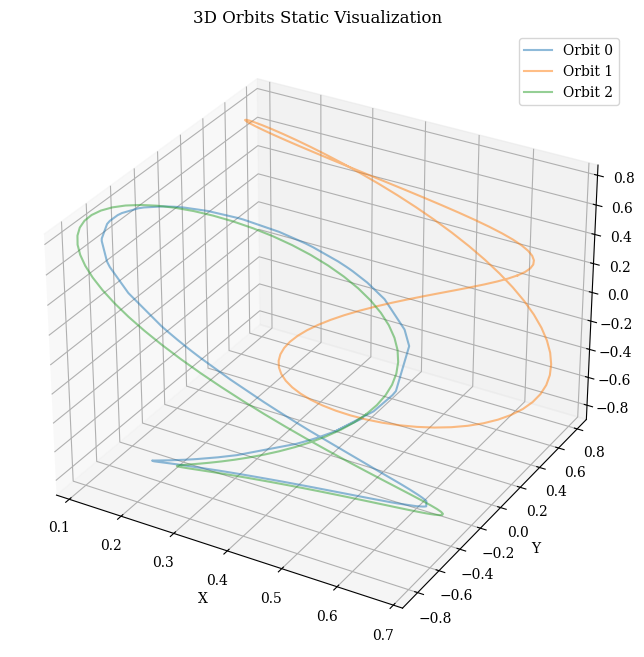

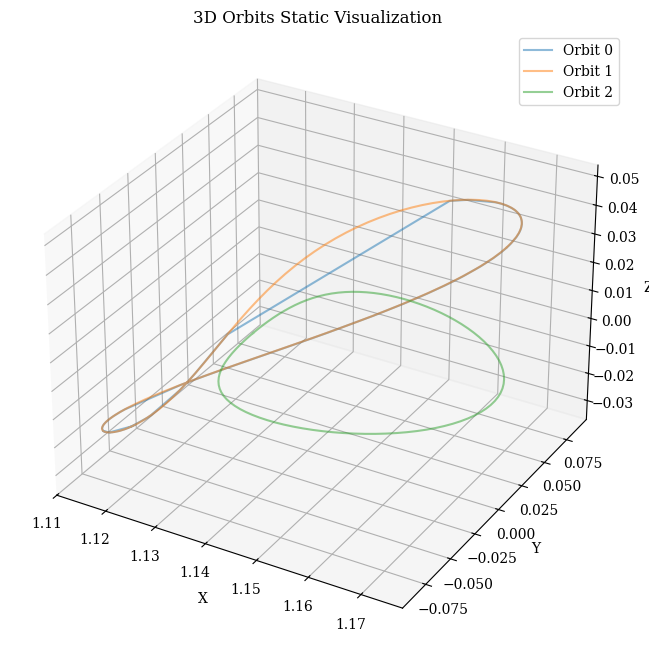

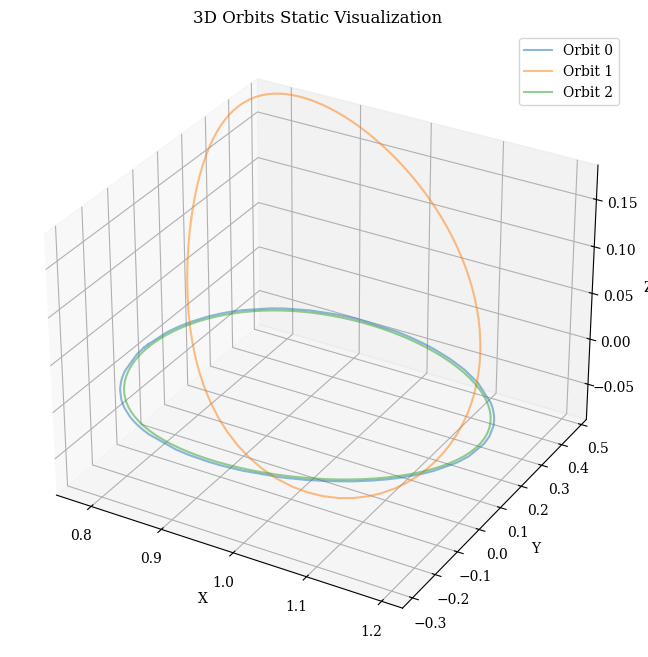

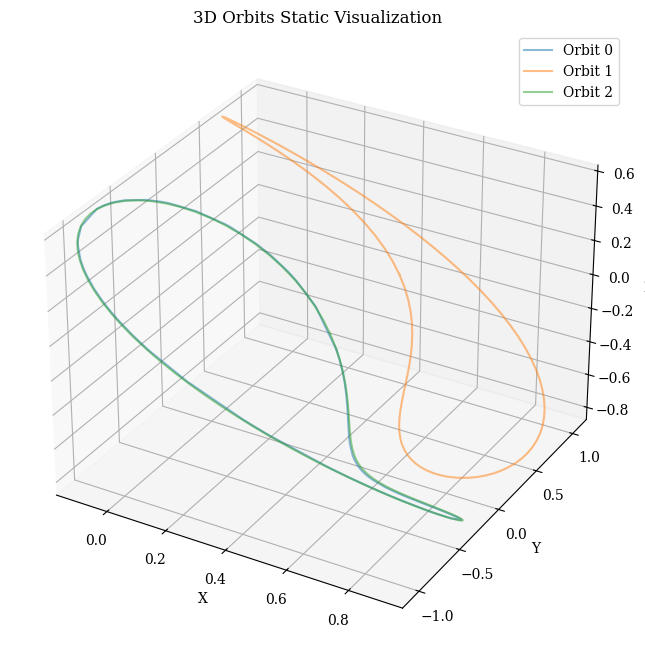

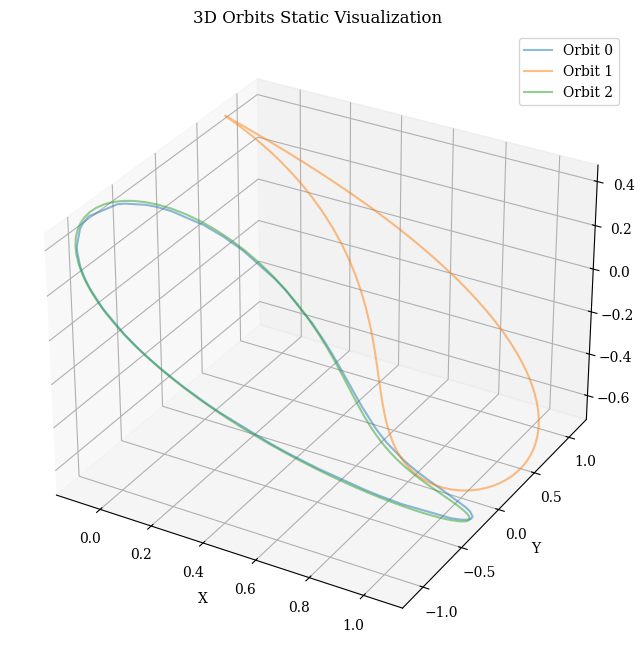

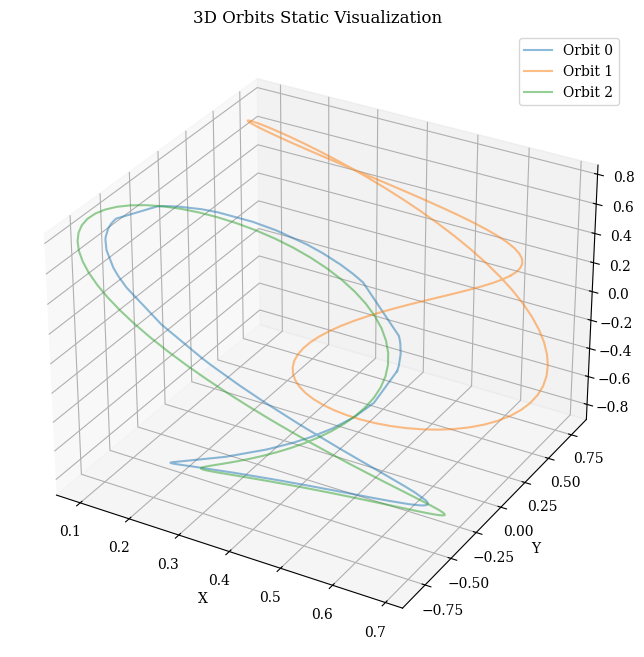

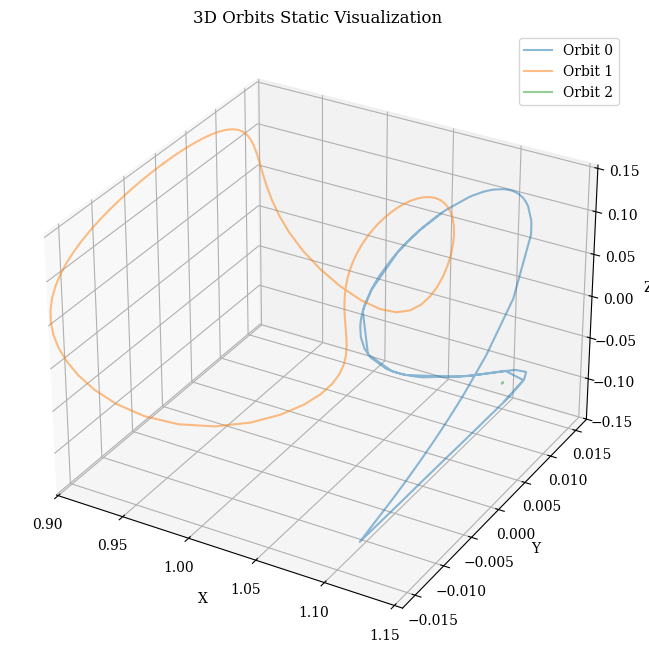

In [ ]:
for i in range(len(refinement_and_closers)):
    visualize_static_orbits(refinement_and_closers[i,:,1:,:])

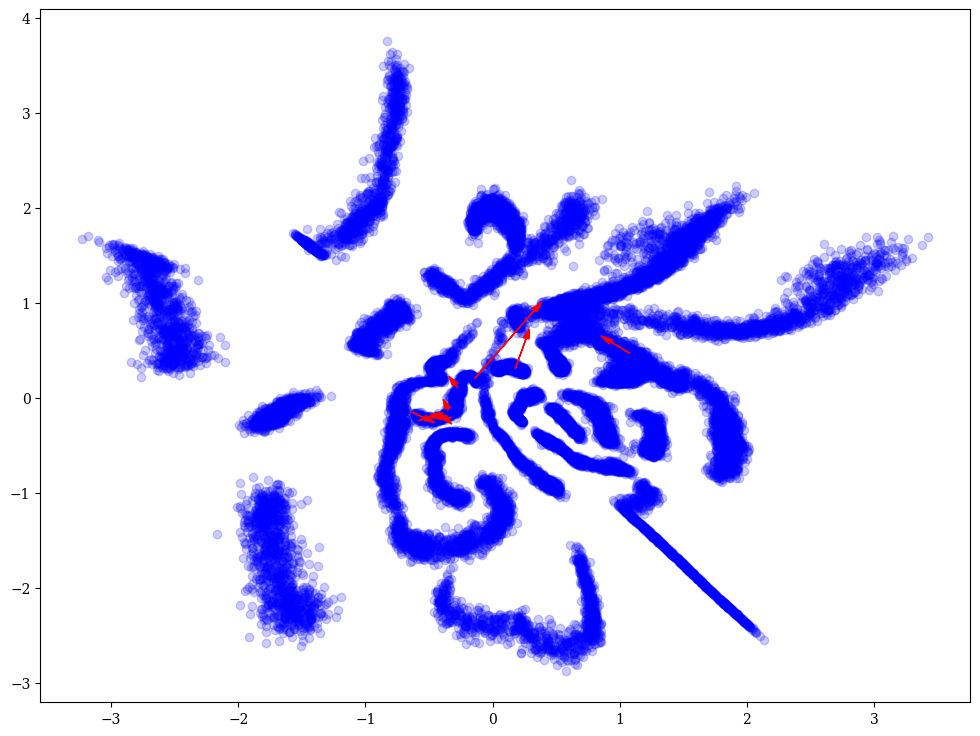

In [ ]:
plot_combined_2d_latent_space(
    real_latent=latent_means, 
    synthetic_latent=generation_to_refinement[refinement_indexes],
    annotation_mode='numbers'
)

In [ ]:
discovery_generation_indexes = discovery_df['id'].values
discovery_generation = generation[discovery_generation_indexes]
discovery_generation.shape

(9, 7, 100)

In [ ]:
discovery_generation_and_refinement = np.stack(
    (discovery_generation, discovery_refinement),
    axis=1
)
discovery_generation_and_refinement.shape

(9, 2, 7, 100)

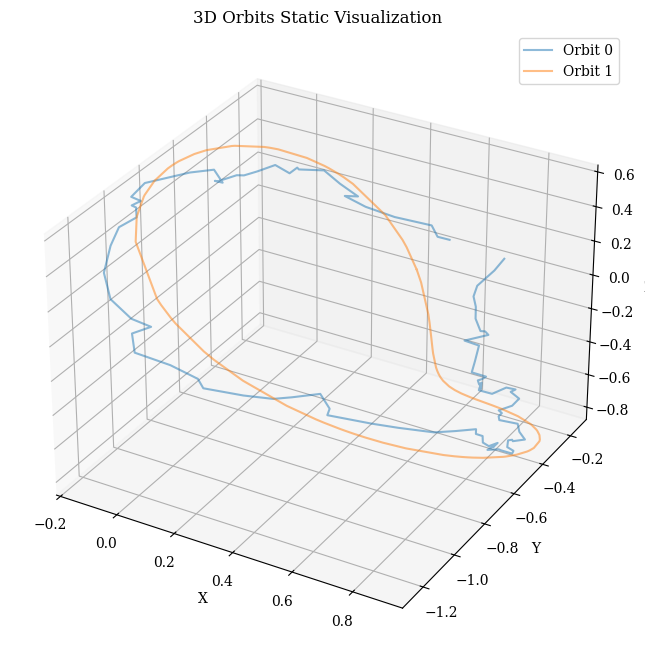

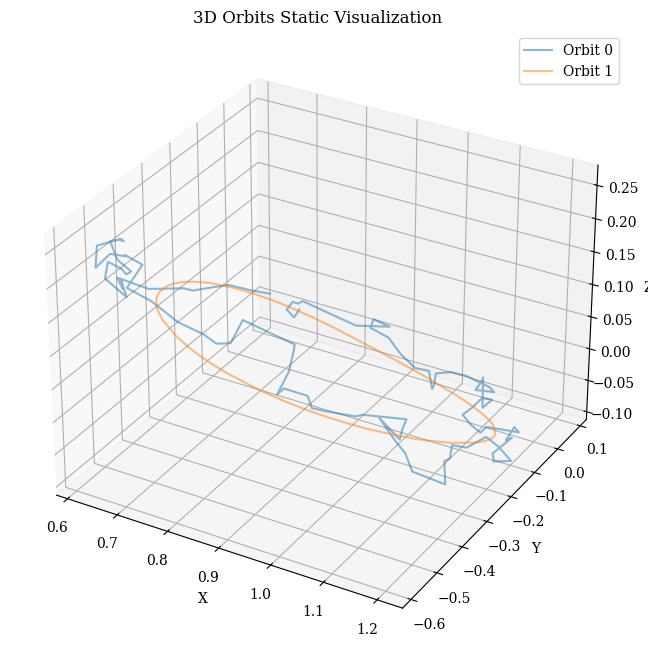

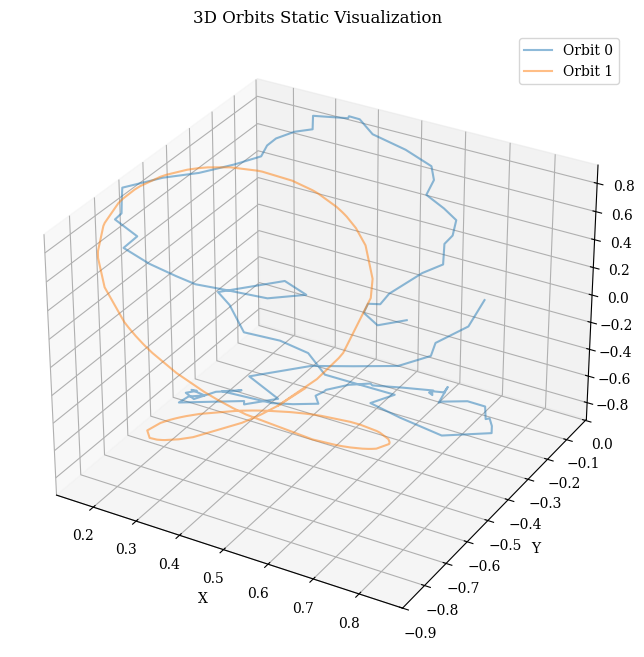

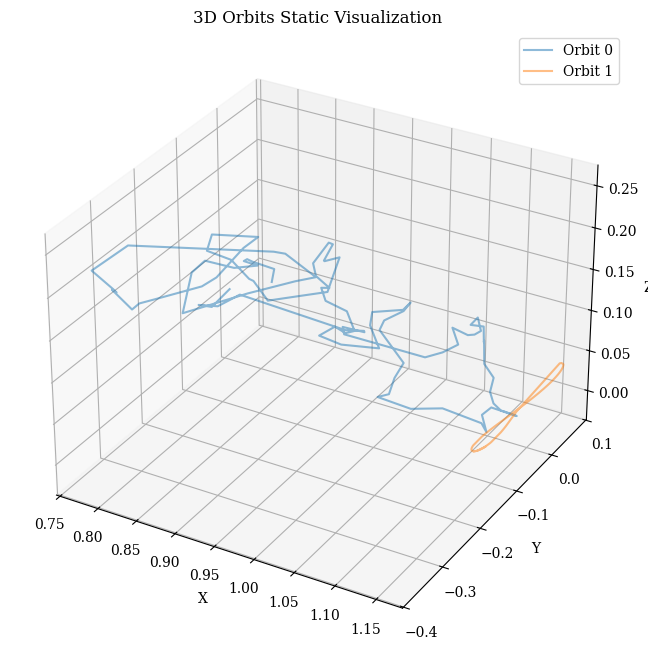

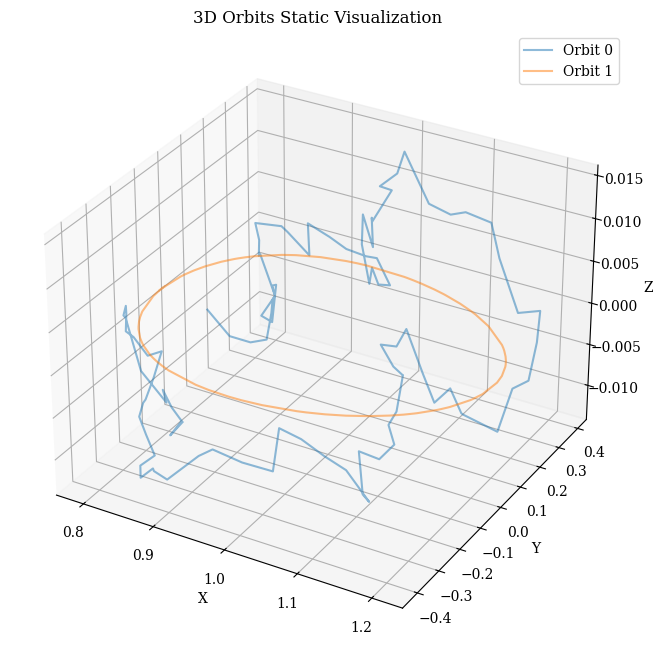

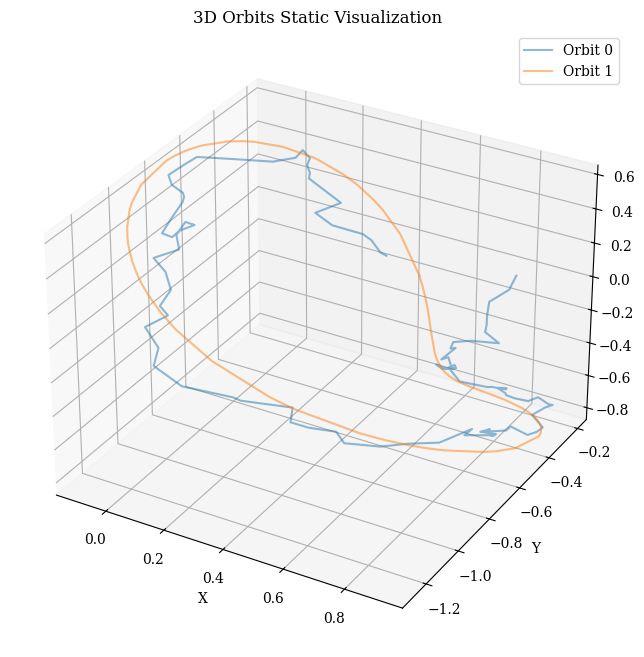

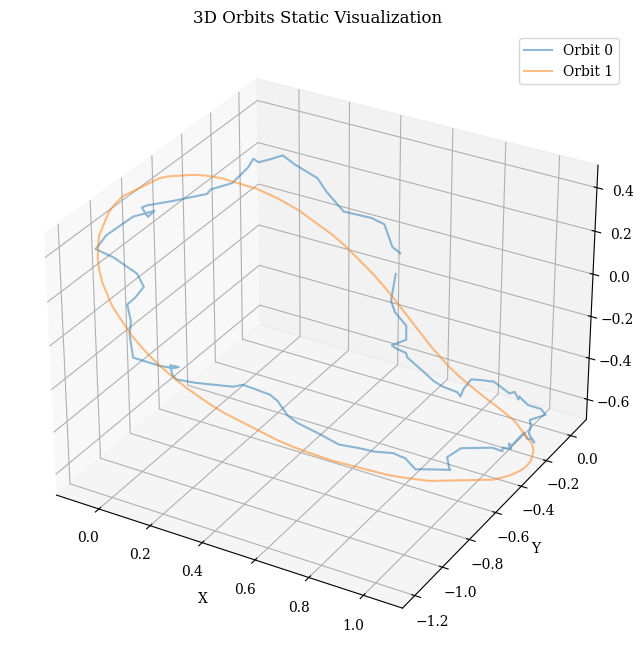

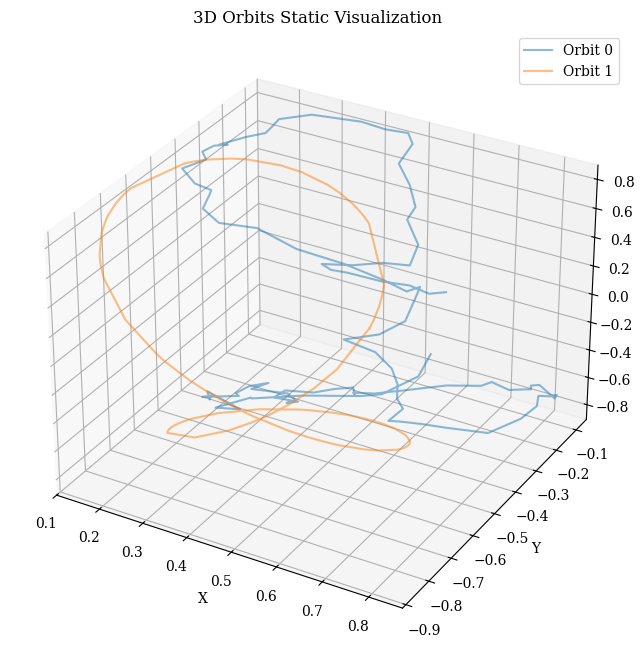

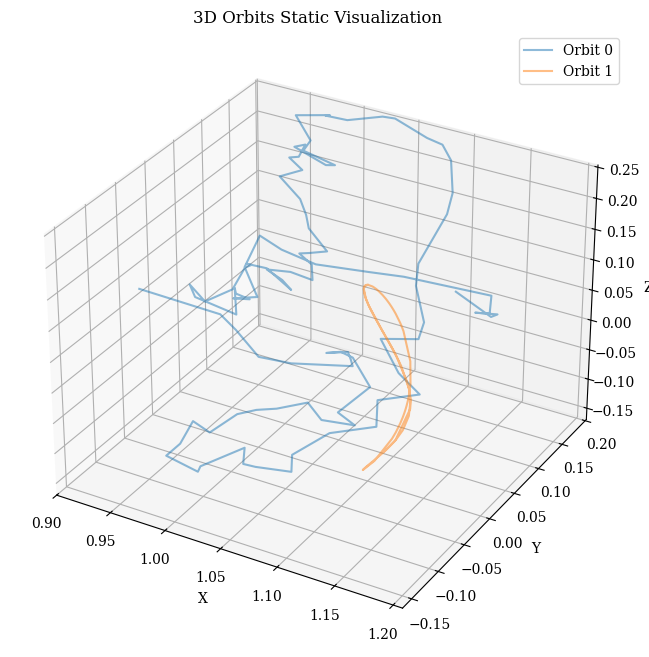

In [ ]:
for i in range(len(discovery_generation_and_refinement)):
    visualize_static_orbits(discovery_generation_and_refinement[i,:,1:,:])